In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
#mpl.use('pdf')
import sys
sys.path.append("../")
import copy
from Plotting.generate_database import ResultsDatabaseGenerator
from common_packages.utilities import get_equivalent_classical_layer_size, get_num_parameters_per_quantum_layer
from Plotting.Plot import BasicPlot, MultiPlot
import pandas as pd
import seaborn as sns
colors =   ["#5dd448",
            "#bfa900",
            "#ec742f",
            "#e9496f",
            "#b04ca4",]

colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 0.5

%load_ext autoreload
%autoreload 2

2023-08-21 11:03:43.447520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64:
2023-08-21 11:03:43.447660: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%matplotlib inline
ex_path = "Synthetic_Hybrid_PWB_Experiment"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[6]['config']
config.pop('__doc__', None)
df = pd.DataFrame(columns=config.keys())
df['avg_acc'] = np.nan
df['acc_err'] = np.nan
df['avg_loss'] = np.nan
df['loss_err'] = np.nan
for i in range(1, len(data) + 1):
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss = metrics.values()
    avg_acc = np.mean(acc)
    acc_err = np.std(acc)
    avg_loss = np.mean(loss)
    loss_err = np.std(loss)
    df.loc[i] = [*config.values(), avg_acc, acc_err, avg_loss, loss_err]
   
    
df = df.sort_values('sigma')
x = np.array(df['sigma'].unique()).astype(float)
x = np.log2(1+1/x)
plot_df = pd.DataFrame(index=x)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,6), sharex=True, sharey=True)
fig.supxlabel('Precision (Bits)')
fig.suptitle('Synthetic Dataset Accuracy Comparison')
for i in range(2,5):

    mask = (df['network_type']=='quantum') & (df['num_qumodes']==i)

    x1 = np.array(df[mask]['sigma'].unique()).astype(float)
    x1 = np.log2(1+1/x1)

    acc_q = df[mask]['avg_acc']
    acc_err_q = df[mask]['acc_err']
    loss_q = df[mask]['avg_loss']
    loss_err_q = df[mask]['loss_err']

    mask = (df['network_type']=='classical') & (df['num_qumodes']==i)

    x2 = np.array(df[mask]['sigma'].unique()).astype(float)
    x2 = np.log2(1+1/x2)
    
    acc_c = df[mask]['avg_acc']
    acc_err_c = df[mask]['acc_err']
    loss_c = df[mask]['avg_loss']
    loss_err_c = df[mask]['loss_err']
    
    mask = (df['network_type']=='classical_tf') & (df['num_qumodes']==i)

    x3 = np.array(df[mask]['sigma'].unique()).astype(float)
    x3 = np.log2(1+1/x3)
    
    acc_tf = df[mask]['avg_acc']
    acc_err_tf = df[mask]['acc_err']
    loss_tf = df[mask]['avg_loss']
    loss_err_tf = df[mask]['loss_err']
    
    #ax[i-2].grid(True, linestyle=':')
    line_q = ax[i-2].plot(x1, acc_q, label='Hybrid', alpha=0.8)
    ax[i-2].fill_between(x1, acc_q - acc_err_q, acc_q + acc_err_q, interpolate=True, alpha=0.3)
    
    line_c = ax[i-2].plot(x2, acc_c, label='Classical', alpha=0.8)
    ax[i-2].fill_between(x2, acc_c - acc_err_c, acc_c + acc_err_c, interpolate=True, alpha=0.3)
    ax[i-2].set_title(f'{i} Qumode')
    
    line_tf = ax[i-2].plot(x3, acc_tf, label='TF', alpha=0.8)
    ax[i-2].fill_between(x3, acc_tf - acc_err_tf, acc_tf + acc_err_tf, interpolate=True, alpha=0.3)
    ax[i-2].hlines([0.9,0.9], 1, 10, color=colors[5], linestyles='--')
    
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=5)
plt.savefig('../MidWinter/Synthetic_comparison.pdf')

FileNotFoundError: [Errno 2] No such file or directory: 'Synthetic_Hybrid_PWB_Experiment'

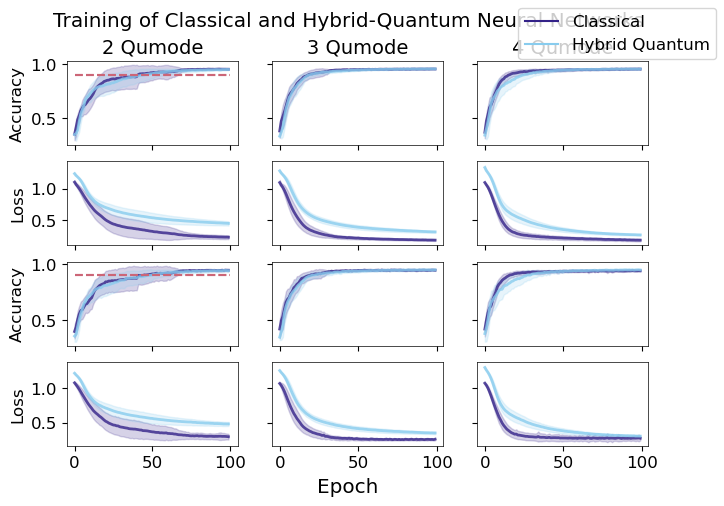

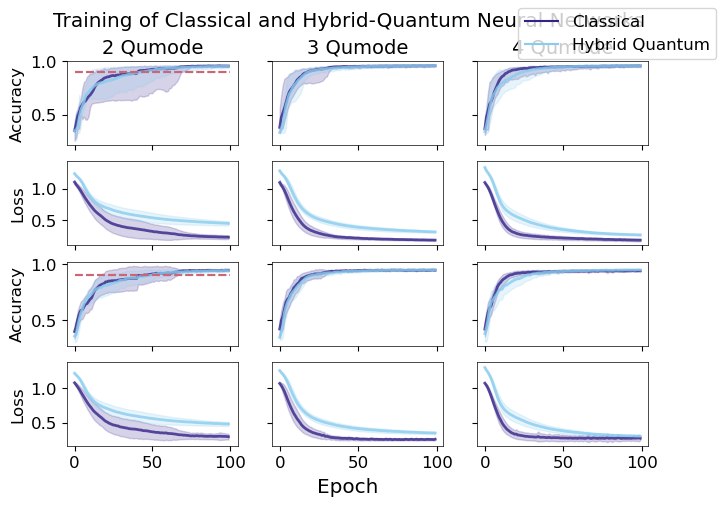

In [3]:
ex_path = "Synthetic_Hybrid_Base_Experiment_100Epochs_2"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[1]['config']
config.pop('__doc__', None)
#config.pop('iteration', None)
df = pd.DataFrame(columns=config.keys())
df['acc'] = np.nan
df['val_acc'] = np.nan
df['loss'] = np.nan
df['val_loss'] = np.nan
for i in range(1, len(data) + 1):
    try:
        config = data[i]['config']
        config.pop('__doc__', None)
        #config.pop('iteration', None)
        metrics = data[i]['metrics']
        metrics.pop('epoch',None)
        acc, loss, val_acc, val_loss = metrics.values()
        acc = np.array(acc)
        assert acc.shape[-1] == 100
        loss = np.array(loss)
        val_acc = np.array(val_acc)
        val_loss = np.array(val_loss)
        df.loc[i] = [*config.values(), acc, val_acc, loss, val_loss]
    except (KeyError, AssertionError):
        print(f"Invalid: {i}")
#df = df.explode(column=['acc', 'val_acc', 'loss', 'val_loss'])
df_mean =df.groupby(['network_type', 'num_qumodes']).apply(lambda x: pd.DataFrame({
    'acc': [np.mean(x['acc'].tolist(), axis=0)],
    'val_acc': [np.mean(x['val_acc'].tolist(), axis=0)],
    'loss': [np.mean(x['loss'].tolist(), axis=0)],
    'val_loss': [np.mean(x['val_loss'].tolist(), axis=0)]
}))
df_mean.reset_index()
"""df_std = df.groupby(['network_type', 'num_qumodes']).apply(
    lambda x: x[['acc','val_acc', 'loss', 'val_loss']].apply(
        lambda y: np.std(y)).rename(columns={
            'acc' : 'acc_std','val_acc':'val_acc_std', 'loss':'loss_std', 'val_loss':'val_loss_std'}))
"""
df_std =df.groupby(['network_type', 'num_qumodes']).apply(lambda x: pd.DataFrame({
    'acc': [np.std(x['acc'].tolist(), axis=0)],
    'val_acc': [np.std(x['val_acc'].tolist(), axis=0)],
    'loss': [np.std(x['loss'].tolist(), axis=0)],
    'val_loss': [np.std(x['val_loss'].tolist(), axis=0)]
}))
df_std.reset_index()

df_min =df.groupby(['network_type', 'num_qumodes']).apply(lambda x: pd.DataFrame({
    'acc': [np.min(x['acc'].tolist(), axis=0)],
    'val_acc': [np.min(x['val_acc'].tolist(), axis=0)],
    'loss': [np.min(x['loss'].tolist(), axis=0)],
    'val_loss': [np.min(x['val_loss'].tolist(), axis=0)]
}))
df_min.reset_index()
df_max =df.groupby(['network_type', 'num_qumodes']).apply(lambda x: pd.DataFrame({
    'acc': [np.max(x['acc'].tolist(), axis=0)],
    'val_acc': [np.max(x['val_acc'].tolist(), axis=0)],
    'loss': [np.max(x['loss'].tolist(), axis=0)],
    'val_loss': [np.max(x['val_loss'].tolist(), axis=0)]
}))
df_max.reset_index()
#df_std.pop(column=3)
#display(df[(df['network_type'] == 'classical') & (df['num_qumodes']==2)])
#fig, ax = plt.subplots(figsize=(8,6))

names = [f'Classical: {get_equivalent_classical_layer_size(i, 2*i, 3)*2*i + 3} parameters' for i in range(2, 5)] \
    + [f'Quantum: {int(get_num_parameters_per_quantum_layer(i))} parameters' for i in range(2, 5)]

q_or_c = ['Classical' for i in range(3)] + ['Quantum' for i in range(3)]
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(7.5, 5), sharey='row', sharex='col')
for i, (mean, std) in enumerate(zip(df_mean['acc'], df_std['acc'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[0,i%3].plot(x, y, lw=2, color=colors[i//3], alpha=0.8, )
    ax[0,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['loss'], df_std['loss'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[1,i%3].plot(x, y, lw=2, alpha=0.8, color=colors[i//3], )
    ax[1,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['val_acc'], df_std['val_acc'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[2,i%3].plot(x, y, lw=2, color=colors[i//3], alpha=0.8, )
    ax[2,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['val_loss'], df_std['val_loss'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[3,i%3].plot(x, y, lw=2, alpha=0.8, color=colors[i//3], )
    ax[3,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

fig.supxlabel('Epoch')
for j,i in enumerate(ax[0]):
    i.set_title(f'{j+2} Qumode', fontsize=14)
ax[0,0].hlines([0.9, 0.9], xmin=0, xmax=100, color=colors[6], linestyles='--')
ax[2,0].hlines([0.9, 0.9], xmin=0, xmax=100, color=colors[6], linestyles='--')
ax[0,0].set_ylabel('Accuracy')
ax[1,0].set_ylabel('Loss')
ax[2,0].set_ylabel('Accuracy')
ax[3,0].set_ylabel('Loss')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.suptitle('Training of Classical and Hybrid-Quantum Neural Networks')
plt.savefig('HybridTraining.pdf')
plt.show()

fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(7.5, 5), sharey='row', sharex='col')
for i, (mean, accmin, accmax) in enumerate(zip(df_mean['acc'], df_min['acc'], df_max['acc'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[0,i%3].plot(x, y, lw=2, color=colors[i//3], alpha=0.8, )
    ax[0,i%3].fill_between(x, accmin, accmax, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['loss'], df_std['loss'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[1,i%3].plot(x, y, lw=2, alpha=0.8, color=colors[i//3], )
    ax[1,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['val_acc'], df_std['val_acc'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[2,i%3].plot(x, y, lw=2, color=colors[i//3], alpha=0.8, )
    ax[2,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['val_loss'], df_std['val_loss'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[3,i%3].plot(x, y, lw=2, alpha=0.8, color=colors[i//3], )
    ax[3,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

fig.supxlabel('Epoch')
for j,i in enumerate(ax[0]):
    i.set_title(f'{j+2} Qumode', fontsize=14)
ax[0,0].hlines([0.9, 0.9], xmin=0, xmax=100, color=colors[6], linestyles='--')
ax[2,0].hlines([0.9, 0.9], xmin=0, xmax=100, color=colors[6], linestyles='--')
ax[0,0].set_ylabel('Accuracy')
ax[1,0].set_ylabel('Loss')
ax[2,0].set_ylabel('Accuracy')
ax[3,0].set_ylabel('Loss')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.suptitle('Training of Classical and Hybrid-Quantum Neural Networks')
plt.savefig('HybridTraining.pdf')
plt.show()




Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 27. Ignoring experiment...
Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 26. Ignoring experiment...


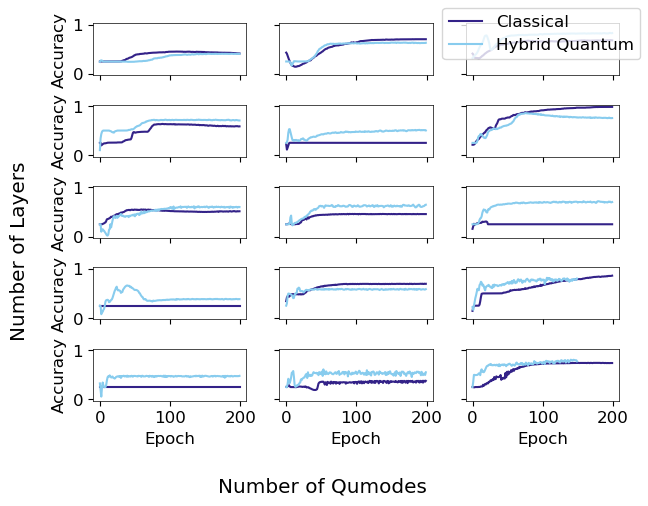

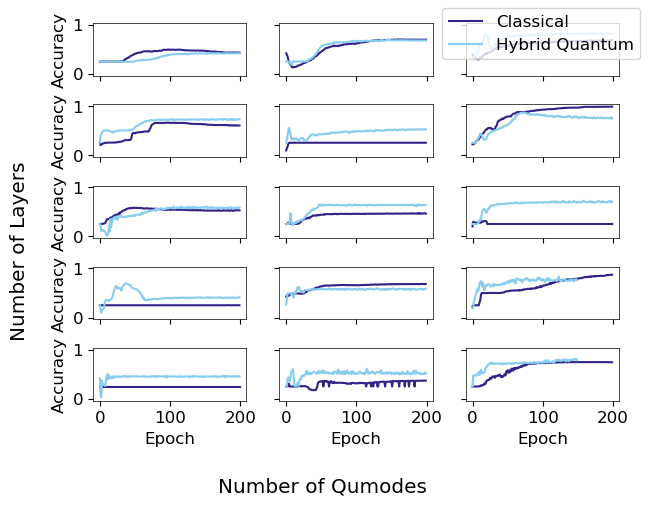

In [4]:
%matplotlib inline
ex_path = "./Synthetic_Quantum_Base_Experiment2"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[1]['config']
config.pop('__doc__', None)
#config.pop('iteration', None)
df = pd.DataFrame(columns=config.keys())
df['num_params'] = np.nan
df['acc'] = np.nan
df['val_acc'] = np.nan
df['loss'] = np.nan
df['val_loss'] = np.nan
for i in data.keys():
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss, num_params, val_acc, val_loss = metrics.values()
    acc = np.array(acc)
    loss = np.array(loss)
    val_acc = np.array(val_acc)
    val_loss = np.array(val_loss)
    df.loc[i] = [*config.values(), num_params[0], acc, val_acc, loss, val_loss]
        
df.sort_values('network_type',inplace=True)
fig, ax = plt.subplots(nrows=df['n_layers'].max(), ncols=df['num_qumodes'].max()-1, figsize=(6.5,5), sharex=True, sharey=True)
for i, row in df.iterrows():
    vals = row['acc']
    idx_row = row['n_layers'] - 1
    idx_col = row['num_qumodes'] - 2
    ax[idx_row, idx_col].plot(vals)
    ax[-1,idx_col].set_xlabel('Epoch')
    ax[idx_row,0].set_ylabel('Accuracy')
fig.supylabel('Number of Layers')
fig.supxlabel('Number of Qumodes')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()
plt.savefig('Training_Nlayers.png')

plt.show()
fig, ax = plt.subplots(nrows=df['n_layers'].max(), ncols=df['num_qumodes'].max()-1, figsize=(6.5,5), sharex=True, sharey=True)
for i, row in df.iterrows():
    vals = row['val_acc']
    idx_row = row['n_layers'] - 1
    idx_col = row['num_qumodes'] - 2
    ax[idx_row, idx_col].plot(vals)
    ax[-1,idx_col].set_xlabel('Epoch')
    ax[idx_row,0].set_ylabel('Accuracy')
fig.supylabel('Number of Layers')
fig.supxlabel('Number of Qumodes')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()
plt.savefig('Validation_Nlayers.png')
plt.show()

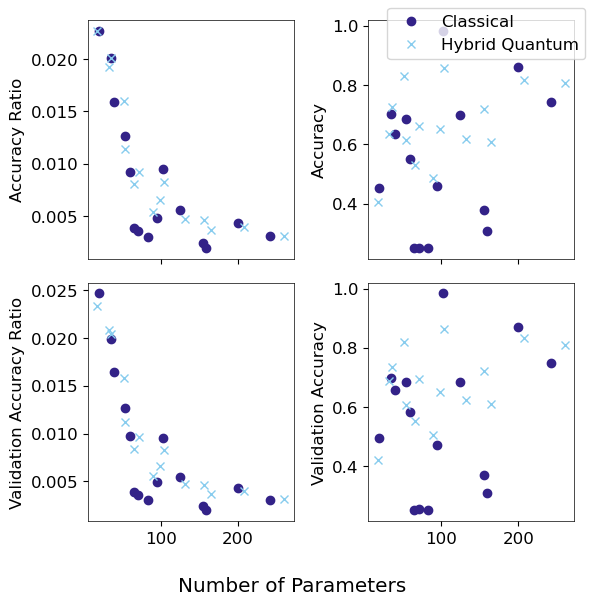

In [6]:
#display(df)
df_max = copy.deepcopy(df)
#display(df_max['acc'])
df_max['acc'] = df_max['acc'].apply(lambda x: np.max(x))
df_max['val_acc'] = df_max['val_acc'].apply(lambda x: np.max(x))
df_max['loss'] = df_max['loss'].apply(lambda x: np.max(x))
df_max['val_loss'] = df_max['val_loss'].apply(lambda x: np.max(x))
df_max['acc_ratio'] = df_max['acc']/df_max['num_params']
df_max['val_acc_ratio'] = df_max['val_acc']/df_max['num_params']

df_classical = df_max[df_max['network_type']=='classical']
df_quantum = df_max[df_max['network_type']=='quantum']

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True)

x,y = df_classical['num_params'], df_classical['acc_ratio']
axs[0,0].plot(x,y, 'o', color=colors[0])
axs[0,0].set_ylabel('Accuracy Ratio')

x,y = df_quantum['num_params'], df_quantum['acc_ratio']
axs[0,0].plot(x,y, 'x', color=colors[1])

x,y = df_classical['num_params'], df_classical['val_acc_ratio']
axs[1,0].plot(x,y, 'o', color=colors[0])
axs[1,0].set_ylabel('Validation Accuracy Ratio')

x,y = df_quantum['num_params'], df_quantum['val_acc_ratio']
axs[1,0].plot(x,y, 'x', color=colors[1])

x,y = df_classical['num_params'], df_classical['acc']
axs[0,1].plot(x,y, 'o', color=colors[0])
axs[0,1].set_ylabel('Accuracy')

x,y = df_quantum['num_params'], df_quantum['acc']
axs[0,1].plot(x,y, 'x', color=colors[1])

x,y = df_classical['num_params'], df_classical['val_acc']
axs[1,1].plot(x,y, 'o', color=colors[0])
axs[1,1].set_ylabel('Validation Accuracy')

x,y = df_quantum['num_params'], df_quantum['val_acc']
axs[1,1].plot(x,y, 'x', color=colors[1])
fig.supxlabel('Number of Parameters')
plt.plot([], 'o', color=colors[0], label='Classical')
plt.plot([], 'x', color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()

plt.savefig('AccPerParam.png')

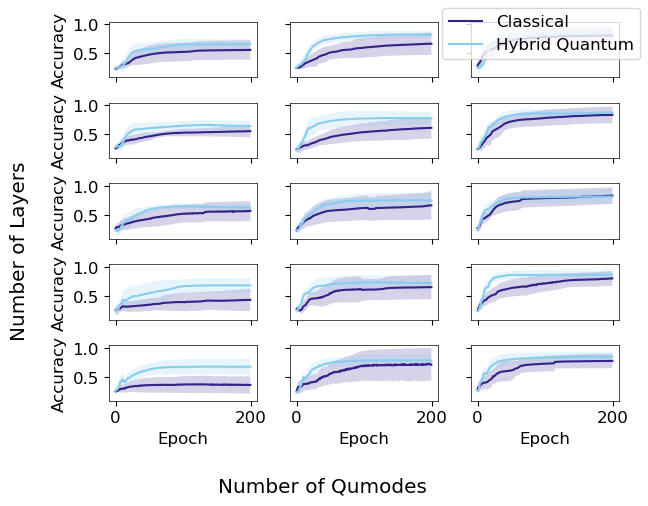

In [7]:
%matplotlib inline
ex_path = "./Synthetic_Quantum_Base_Experiment3"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[1]['config']
config.pop('__doc__', None)
#config.pop('iteration', None)
df = pd.DataFrame(columns=config.keys())
df['num_params'] = np.nan
df['acc'] = np.nan
df['val_acc'] = np.nan
df['loss'] = np.nan
df['val_loss'] = np.nan
for i in data.keys():
    config = data[i]['config']
    config.pop('__doc__', None)
    if config['iteration'] != -1:
        metrics = data[i]['metrics']
        metrics.pop('epoch',None)
        acc, loss, num_params, val_acc, val_loss = metrics.values()
        acc = np.array(acc)
        loss = np.array(loss)
        val_acc = np.array(val_acc)
        val_loss = np.array(val_loss)
        df.loc[i] = [*config.values(), num_params[0], acc, val_acc, loss, val_loss]

df_mean = df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params']).apply(lambda x: pd.DataFrame({
    'acc': [np.mean(x['acc'].tolist(), axis=0)],
    'val_acc': [np.mean(x['val_acc'].tolist(), axis=0)],
    'loss': [np.mean(x['loss'].tolist(), axis=0)],
    'val_loss': [np.mean(x['val_loss'].tolist(), axis=0)]
}))
df_std =df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params']).apply(lambda x: pd.DataFrame({
    'acc_std': [np.std(x['acc'].tolist(), axis=0)],
    'val_acc_std': [np.std(x['val_acc'].tolist(), axis=0)],
    'loss_std': [np.std(x['loss'].tolist(), axis=0)],
    'val_loss_std': [np.std(x['val_loss'].tolist(), axis=0)]
}))

df_max = df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params']).apply(lambda x: pd.DataFrame({
    'acc_max': [np.max(x['acc'].tolist(), axis=0)],
    'val_acc_max': [np.max(x['val_acc'].tolist(), axis=0)],
    'loss_max': [np.max(x['loss'].tolist(), axis=0)],
    'val_loss_max': [np.max(x['val_loss'].tolist(), axis=0)]
}))

df_min = df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params']).apply(lambda x: pd.DataFrame({
    'acc_min': [np.min(x['acc'].tolist(), axis=0)],
    'val_acc_min': [np.min(x['val_acc'].tolist(), axis=0)],
    'loss_min': [np.min(x['loss'].tolist(), axis=0)],
    'val_loss_min': [np.min(x['val_loss'].tolist(), axis=0)]
}))

df = pd.concat([df_mean, df_std, df_min, df_max], axis=1)
df.reset_index(inplace=True)
df.drop(columns='level_4', inplace=True)
df.sort_values('network_type',inplace=True)
fig, ax = plt.subplots(nrows=df['n_layers'].max(), ncols=df['num_qumodes'].max()-1, figsize=(6.5,5), sharex=True, sharey=True)
for i,row in df.iterrows():
    vals = row['acc']
    idx_row = row['n_layers'] - 1
    idx_col = row['num_qumodes'] - 2
    ax[idx_row, idx_col].plot(vals)
    ax[idx_row, idx_col].fill_between([i for i in range(len(vals))], row['acc'] - row['acc_std'], row['acc'] + row['acc_std'], alpha=0.2) 
    ax[-1,idx_col].set_xlabel('Epoch')
    ax[idx_row,0].set_ylabel('Accuracy')
    
fig.supylabel('Number of Layers')
fig.supxlabel('Number of Qumodes')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()

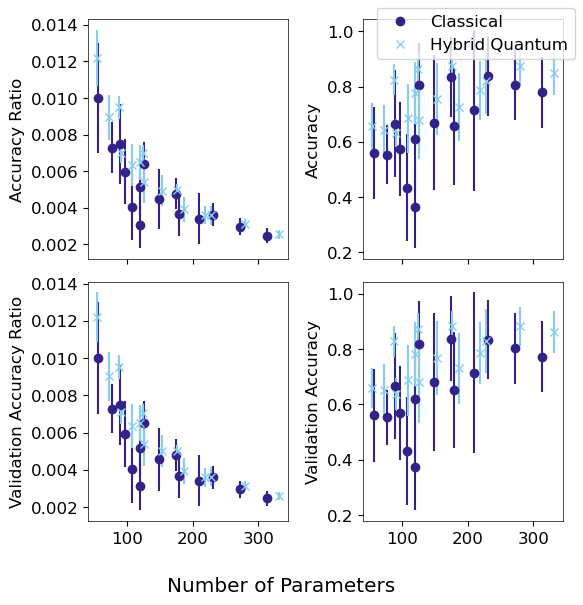

In [8]:
df_mean = copy.deepcopy(df)
df_mean['acc'] = df_mean['acc'].apply(lambda x: x[-1])
df_mean['acc_std'] = df_mean['acc_std'].apply(lambda x: x[-1])
df_mean['val_acc'] = df_mean['val_acc'].apply(lambda x: x[-1])
df_mean['val_acc_std'] = df_mean['val_acc_std'].apply(lambda x: x[-1])
df_mean['loss'] = df_mean['loss'].apply(lambda x: x[-1])
df_mean['loss_std'] = df_mean['loss_std'].apply(lambda x: x[-1])
df_mean['val_loss'] = df_mean['val_loss'].apply(lambda x: x[-1])
df_mean['val_loss_std'] = df_mean['val_loss_std'].apply(lambda x: x[-1])
df_mean['acc_ratio'] = df_mean['acc']/df_mean['num_params']
df_mean['acc_ratio_std'] = df_mean['acc_std']/df_mean['num_params']
df_mean['val_acc_ratio'] = df_mean['val_acc']/df_mean['num_params']
df_mean['val_acc_ratio_std'] = df_mean['val_acc_std']/df_mean['num_params']
df_classical = df_mean[df_mean['network_type']=='classical']
df_quantum = df_mean[df_mean['network_type']=='quantum']
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True)

x,y = df_classical['num_params'], df_classical['acc_ratio']
axs[0,0].errorbar(x,y, yerr=df_classical['acc_ratio_std'], fmt='o',ecolor=colors[0], color=colors[0])
axs[0,0].set_ylabel('Accuracy Ratio')

x,y = df_quantum['num_params'], df_quantum['acc_ratio']
axs[0,0].errorbar(x,y,  yerr=df_quantum['acc_ratio_std'], fmt='x', color=colors[1])

x,y = df_classical['num_params'], df_classical['val_acc_ratio']
axs[1,0].errorbar(x,y, yerr=df_classical['val_acc_ratio_std'], fmt='o', color=colors[0])
axs[1,0].set_ylabel('Validation Accuracy Ratio')

x,y = df_quantum['num_params'], df_quantum['val_acc_ratio']
axs[1,0].errorbar(x,y, yerr=df_quantum['val_acc_ratio_std'], fmt='x', ecolor=colors[1], color=colors[1])

x,y = df_classical['num_params'], df_classical['acc']
axs[0,1].errorbar(x,y, yerr=df_classical['acc_std'], fmt='o', color=colors[0])
axs[0,1].set_ylabel('Accuracy')

x,y = df_quantum['num_params'], df_quantum['acc']
axs[0,1].errorbar(x,y, yerr=df_quantum['acc_std'], fmt='x', color=colors[1])

x,y = df_classical['num_params'], df_classical['val_acc']
axs[1,1].errorbar(x,y, yerr=df_classical['val_acc_std'], fmt='o', color=colors[0])
axs[1,1].set_ylabel('Validation Accuracy')

x,y = df_quantum['num_params'], df_quantum['val_acc']
axs[1,1].errorbar(x,y, yerr=df_quantum['val_acc_std'], fmt='x', color=colors[1])
fig.supxlabel('Number of Parameters')
plt.errorbar([], [], fmt='o', ecolor=colors[0], color=colors[0], label='Classical')
plt.errorbar([], [], fmt='x', color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()

In [5]:
ex_path = "/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep"
ex_path_kerr = "/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Kerr"

def generate_database(ex_path):
    dbGen = ResultsDatabaseGenerator()
    dbGen.initialize_from_folder(ex_path)
    data = dbGen.data
    config = data[1]['config']
    config.pop('__doc__', None)
    #config.pop('iteration', None)
    df = pd.DataFrame(columns=config.keys())
    df['num_params'] = np.nan
    df['acc'] = np.nan
    df['val_acc'] = np.nan
    df['loss'] = np.nan
    df['val_loss'] = np.nan
    for i in data.keys():
        config = data[i]['config']
        config.pop('__doc__', None)
        if config['iteration'] != -1:
            metrics = data[i]['metrics']
            metrics.pop('epoch',None)
            acc, loss, num_params, val_acc, val_loss = metrics.values()
            acc = np.array(acc)
            loss = np.array(loss)
            val_acc = np.array(val_acc)
            val_loss = np.array(val_loss)
            df.loc[i] = [*config.values(), num_params[0], acc, val_acc, loss, val_loss]
    return df


df_orig = generate_database(ex_path)
df_kerr = generate_database(ex_path_kerr)
display(df_orig.head())
display(df_kerr.head())

df_kerr.drop(df_kerr.loc[(df_kerr['network_type']=='classical') & (df_kerr['num_qumodes']==4)].index, inplace=True)
df_kerr.drop(df_kerr.loc[(df_kerr['network_type']=='classical') & (df_kerr['n_layers']==4)].index, inplace=True)
df_kerr.drop(df_kerr.loc[(df_kerr['network_type']=='classical') & (df_kerr['n_layers']==5)].index, inplace=True)

Exception Expecting value: line 1 column 1 (char 0)
Error reading from metrics file /home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep/915 . Ignoring file...
Exception Expecting value: line 1 column 1 (char 0)
Error reading from metrics file /home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep/880 . Ignoring file...
Exception Expecting value: line 1 column 1 (char 0)
Error reading from metrics file /home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep/917 . Ignoring file...
Exception Expecting value: line 1 column 1 (char 0)
Error reading from metrics file /home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep/867 . Ignoring file...
Exception Expecting value: line 1 column 1 (char 0)
Error reading from metrics file /home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep/918 . Ignoring file...
Exception Expecting 

,cutoff,iteration,n_layers,network_type,num_qumodes,num_params,acc,val_acc,loss,val_loss
1031,1,5,4,quantum,4,280,"[0.24857142567634583, 0.24857142567634583, 0.2...","[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2...","[1.4302260875701904, 1.3969779014587402, nan, ...","[1.4109349250793457, 1.3928357362747192, nan, ..."
49,8,1,3,quantum,3,153,"[0.2514285743236542, 0.3028571307659149, 0.372...","[0.25333333015441895, 0.33666667342185974, 0.3...","[1.7625699043273926, 1.742352843284607, 1.7216...","[1.7520743608474731, 1.7313326597213745, 1.711..."
181,1,3,1,quantum,2,54,"[0.24857142567634583, 0.24857142567634583, 0.2...","[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1014,1,5,4,quantum,4,280,"[0.24857142567634583, 0.24857142567634583, 0.2...","[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2...","[1.4302260875701904, 1.3969779014587402, nan, ...","[1.4109349250793457, 1.3928357362747192, nan, ..."
363,1,8,3,classical,3,149,"[0.25999999046325684, 0.26428571343421936, 0.2...","[0.27666667103767395, 0.2666666805744171, 0.25...","[1.3936223983764648, 1.3882509469985962, 1.376...","[1.3927116394042969, 1.383899211883545, 1.3684..."


,cutoff,iteration,n_layers,network_type,num_qumodes,num_params,acc,val_acc,loss,val_loss
49,5,5,1,quantum,2,190,"[0.20714285969734192, 0.23571428656578064, 0.2...","[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2...","[1.5348541736602783, 1.530426025390625, 1.5260...","[1.5323748588562012, 1.5279744863510132, 1.523..."
181,classical,5,2,classical,2,221,"[0.25, 0.25, 0.2571428716182709, 0.32714286446...","[0.25, 0.25, 0.2800000011920929, 0.35333332419...","[1.4020166397094727, 1.3867017030715942, 1.375...","[1.3958840370178223, 1.3823498487472534, 1.371..."
242,classical,9,2,classical,4,459,"[0.27000001072883606, 0.3471428453922272, 0.35...","[0.33666667342185974, 0.36666667461395264, 0.3...","[1.3915773630142212, 1.377332329750061, 1.3696...","[1.3854659795761108, 1.380081295967102, 1.3719..."
52,10,5,1,quantum,3,289,"[0.24714285135269165, 0.25999999046325684, 0.2...","[0.2266666740179062, 0.2199999988079071, 0.256...","[1.7590668201446533, 1.7476123571395874, 1.733...","[1.7544431686401367, 1.743351697921753, 1.7306..."
27,10,3,1,quantum,2,190,"[0.21142856776714325, 0.22142857313156128, 0.2...","[0.18000000715255737, 0.25333333015441895, 0.2...","[1.6455639600753784, 1.6410499811172485, 1.636...","[1.6430045366287231, 1.6385931968688965, 1.634..."


In [37]:
df_orig.loc[df_orig['network_type']=='classical', 'cutoff'] = 'classical'
df_orig.drop(df_orig[df_orig['cutoff']==1].index, inplace=True)
def process_data(df, groups=['network_type', 'n_layers', 'num_qumodes', 'num_params', 'cutoff']):
    df_mean = df.groupby(groups).apply(lambda x: pd.DataFrame({
        'acc': [np.mean(x['acc'].tolist(), axis=0)],
        'val_acc': [np.mean(x['val_acc'].tolist(), axis=0)],
        'loss': [np.mean(x['loss'].tolist(), axis=0)],
        'val_loss': [np.mean(x['val_loss'].tolist(), axis=0)],
        'num_exps': [len(x['acc'].tolist())]
    }))

    df_std = df.groupby(groups).apply(lambda x: pd.DataFrame({
        'acc_std': [np.std(x['acc'].tolist(), axis=0)],
        'val_acc_std': [np.std(x['val_acc'].tolist(), axis=0)],
        'loss_std': [np.std(x['loss'].tolist(), axis=0)],
        'val_loss_std': [np.std(x['val_loss'].tolist(), axis=0)]
    }))
    df_max = df.groupby(groups).apply(lambda x: pd.DataFrame({
        'acc_max': [np.max(x['acc'].tolist(), axis=0)],
        'val_acc_max': [np.max(x['val_acc'].tolist(), axis=0)],
        'loss_min': [np.min(x['loss'].tolist(), axis=0)],
        'val_loss_min': [np.min(x['val_loss'].tolist(), axis=0)]
    }))
    df_out = pd.concat([df_mean, df_std, df_max], axis=1)
    df_out.reset_index(inplace=True)
    df_out.drop(columns=f'level_{len(groups)}', inplace=True)
    df_out.sort_values(['network_type', 'num_qumodes', 'n_layers'],inplace=True)
    return df_out
df_o = process_data(df_orig)
df_k = process_data(df_kerr)

def plot_training_cutoff_sweep(df, fname='cutoff_sweep', dataset='training'):

    for n in df['num_qumodes'].unique():
        fig, axs = plt.subplots(ncols=2, nrows=len(df['n_layers'].unique()), figsize=(6,6), sharex=True)
        color_dict = dict(zip(df[df['num_qumodes']==n]['cutoff'].unique(), colors))
        color_dict['classical'] = colors[-1]
        for i in df['n_layers'].unique():
            ax2  = axs[i-1,1].twinx()
            ax2.set_yticks([])
            ax2.set_yticklabels([])
            ax2.set_ylabel(f'{i} Layers')
        prefix = 'val_' if dataset=='validation' else '' 
        for i, row in df[df['num_qumodes']==n].iterrows():
            idx_row = row['n_layers'] - 1
            epochs = [i for i in range(len(row[prefix+'acc']))]
            axs[idx_row, 0].plot(epochs, row[prefix+'acc'], color=color_dict[row['cutoff']])
            axs[idx_row, 1].plot(epochs, row[prefix+'loss'], color=color_dict[row['cutoff']])
            
            axs[-1,0].set_xlabel('Epoch')
            axs[-1,1].set_xlabel('Epoch')
            axs[idx_row,0].set_ylabel('Accuracy')
            axs[idx_row,1].set_ylabel('Loss')


        for key,val in color_dict.items():
            plt.plot([], [], color=val, label=f'{key}'.capitalize())

        fig.legend()
        fig.tight_layout()
        fig.suptitle(f'{dataset.capitalize()}: {n} Qumodes')
        plt.savefig(f'./cutoff_sweep_plots/{fname}_{dataset.capitalize()}_{n}qumodes.png', dpi=300)
        plt.show()

# plot_training_cutoff_sweep(df_o, 'cutoff_sweep')
# plot_training_cutoff_sweep(df_o, 'cutoff_sweep', dataset='validation')
# print('Kerr Encoding')
# plot_training_cutoff_sweep(df_k, 'cutoff_sweep_kerr')
# plot_training_cutoff_sweep(df_k, 'cutoff_sweep_kerr', dataset='validation')
display(df_o[df_o['network_type']=='quantum'])
display(df_k[df_k['network_type']=='quantum'])


,network_type,n_layers,num_qumodes,num_params,cutoff,acc,val_acc,loss,val_loss,num_exps,acc_std,val_acc_std,loss_std,val_loss_std,acc_max,val_acc_max,loss_min,val_loss_min
15,quantum,1,2,54,3,"[0.2425714313983917, 0.24285714328289032, 0.25...","[0.2380000025033951, 0.24666666686534883, 0.25...","[1.472895359992981, 1.4643753290176391, 1.4561...","[1.4694788455963135, 1.46112117767334, 1.45326...",5,"[0.019259774395465286, 0.032513735483408523, 0...","[0.033373312123639295, 0.06121002393932203, 0....","[0.01763762298396419, 0.015377027167030164, 0....","[0.017351146526875843, 0.015368526241860163, 0...","[0.2542857229709625, 0.2785714268684387, 0.345...","[0.27000001072883606, 0.3400000035762787, 0.37...","[1.4502453804016113, 1.4433306455612183, 1.436...","[1.445317029953003, 1.4387706518173218, 1.4323..."
16,quantum,1,2,54,5,"[0.2731428563594818, 0.27057142555713654, 0.27...","[0.27333333194255827, 0.27133333384990693, 0.2...","[1.5533379554748534, 1.5404749631881713, 1.528...","[1.5460720539093018, 1.5339197397232056, 1.522...",5,"[0.04702930046260418, 0.045621329564048886, 0....","[0.0518116246635102, 0.05140687421363681, 0.04...","[0.042424527588966476, 0.03898308488340383, 0....","[0.04274225387058085, 0.03999979359276729, 0.0...","[0.36714285612106323, 0.36142855882644653, 0.3...","[0.3766666650772095, 0.3733333349227905, 0.363...","[1.5122014284133911, 1.500304102897644, 1.4867...","[1.5025556087493896, 1.4881668090820312, 1.475..."
17,quantum,1,2,54,7,"[0.2749999985098839, 0.28535714745521545, 0.30...","[0.2874999940395355, 0.3033333271741867, 0.324...","[1.559622347354889, 1.5467762649059296, 1.5344...","[1.5513748526573181, 1.5385250747203827, 1.526...",4,"[0.03483927765595705, 0.04316999146744418, 0.0...","[0.0573669927395956, 0.06612277957835527, 0.08...","[0.06520545481657494, 0.0614786935463823, 0.05...","[0.06302457638573429, 0.059288762812238535, 0....","[0.334285706281662, 0.3557142913341522, 0.3957...","[0.3866666555404663, 0.41333332657814026, 0.46...","[1.50667405128479, 1.4922293424606323, 1.47913...","[1.4952750205993652, 1.481447458267212, 1.4699..."
18,quantum,1,2,54,8,"[0.2696428596973419, 0.27250000089406967, 0.26...","[0.28166666626930237, 0.2783333286643028, 0.28...","[1.5765739977359772, 1.5618251860141754, 1.548...","[1.5656286478042603, 1.5517531037330627, 1.539...",4,"[0.03403742386796452, 0.034983590508714524, 0....","[0.042064760779063404, 0.039756201976838094, 0...","[0.013253625476238741, 0.007619113758311505, 0...","[0.012469180861483404, 0.00822978232303514, 0....","[0.3285714387893677, 0.3328571319580078, 0.325...","[0.35333332419395447, 0.3466666638851166, 0.34...","[1.5571749210357666, 1.5498178005218506, 1.542...","[1.5448659658432007, 1.537522554397583, 1.5303..."
19,quantum,1,2,54,9,"[0.24892856925725937, 0.24535714089870453, 0.2...","[0.24500000104308128, 0.23499999940395355, 0.2...","[1.6449649333953857, 1.6247451901435852, 1.606...","[1.6348916590213776, 1.6152439713478088, 1.596...",4,"[0.0015567527775363786, 0.007310534036631041, ...","[0.006871842480472265, 0.0240947232811907, 0.0...","[0.05759121997217981, 0.04449621051111469, 0.0...","[0.05333696248114123, 0.040906739700763806, 0....","[0.2514285743236542, 0.2514285743236542, 0.251...","[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2...","[1.5896316766738892, 1.5811375379562378, 1.573...","[1.585456371307373, 1.577649712562561, 1.56905..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,quantum,4,4,280,5,"[0.25238094727198285, 0.2566666652758916, 0.27...","[0.27444444100062054, 0.27888889114061993, 0.2...","[1.7841161092122395, 1.74375319480896, 1.70688...","[1.7599269946416218, 1.7222935756047566, 1.686...",3,"[0.005387477106703044, 0.02011305613933264, 0....","[0.03695174650182461, 0.03614102094073816, 0.0...","[0.019030024590756728, 0.01800572934709193, 0....","[0.019147823241668596, 0.017416361889644915, 0...","[0.25999999046325684, 0.2785714268684387, 0.32...","[0.3266666531562805, 0.3300000

,network_type,n_layers,num_qumodes,num_params,cutoff,acc,val_acc,loss,val_loss,num_exps,acc_std,val_acc_std,loss_std,val_loss_std,acc_max,val_acc_max,loss_min,val_loss_min
6,quantum,1,2,190,5,"[0.24071428626775743, 0.2601428598165512, 0.26...","[0.25766666531562804, 0.2573333323001862, 0.27...","[1.5350374102592468, 1.5304051995277406, 1.525...","[1.5324249029159547, 1.5277433753013612, 1.522...",10,"[0.013616467873924435, 0.02363368572709729, 0....","[0.014302289720025202, 0.03079682734581681, 0....","[0.0005300248315528896, 0.0003180726664503971,...","[0.0002666631167901678, 0.00034543100414797655...","[0.25285714864730835, 0.3157142996788025, 0.32...","[0.2933333218097687, 0.3400000035762787, 0.360...","[1.5347851514816284, 1.5300350189208984, 1.524...","[1.5321006774902344, 1.527005672454834, 1.5182..."
7,quantum,1,2,190,10,"[0.243428573012352, 0.26728571355342867, 0.281...","[0.2609999984502792, 0.27000000029802323, 0.28...","[1.646793508529663, 1.6394283175468445, 1.6330...","[1.6433048367500305, 1.6367659091949462, 1.630...",10,"[0.032608999273861294, 0.03849967088003955, 0....","[0.0563530497345677, 0.05179017582284982, 0.04...","[0.007024183782563803, 0.003591911512943162, 0...","[0.005540637187684436, 0.0030585874620646532, ...","[0.28999999165534973, 0.3157142996788025, 0.34...","[0.3466666638851166, 0.3400000035762787, 0.340...","[1.6408209800720215, 1.6337882280349731, 1.626...","[1.6377032995224, 1.631332278251648, 1.6249215..."
10,quantum,2,2,208,5,"[0.25985714346170424, 0.2602857157588005, 0.25...","[0.27033333480358124, 0.26466666758060453, 0.2...","[1.562238883972168, 1.551229441165924, 1.54014...","[1.5563461542129517, 1.5456095099449159, 1.534...",10,"[0.04374065634662073, 0.02973900318418685, 0.0...","[0.0450296231120895, 0.02875954244985123, 0.04...","[0.008096626646765605, 0.013932312805445522, 0...","[0.010594923132625826, 0.01595143743345831, 0....","[0.3857142925262451, 0.3442857265472412, 0.302...","[0.39666667580604553, 0.33000001311302185, 0.3...","[1.538649320602417, 1.5099605321884155, 1.4806...","[1.5252389907836914, 1.4982621669769287, 1.471..."
11,quantum,2,2,208,10,"[0.2362857148051262, 0.2552857130765915, 0.272...","[0.25299999862909317, 0.26699999868869784, 0.2...","[1.682407295703888, 1.6695335149765014, 1.6585...","[1.674282717704773, 1.6634150385856628, 1.6529...",10,"[0.04778438117368997, 0.05497699035604112, 0.0...","[0.05653808796081874, 0.07501777378345369, 0.0...","[0.008946894423989708, 0.010764971100484537, 0...","[0.00986693336665894, 0.012097800217379575, 0....","[0.3199999928474426, 0.35285714268684387, 0.36...","[0.3499999940395355, 0.3799999952316284, 0.363...","[1.664933681488037, 1.640703797340393, 1.62341...","[1.6487833261489868, 1.6309601068496704, 1.616..."
14,quantum,3,2,226,5,"[0.23730158805847168, 0.24761904941664803, 0.2...","[0.24481481479273903, 0.2562962936030494, 0.25...","[1.5864128006829157, 1.5730922089682684, 1.559...","[1.5790653626124065, 1.5658163626988728, 1.552...",9,"[0.021022009972361748, 0.0062087648412424805, ...","[0.014665918487049649, 0.014609686271594072, 0...","[0.0021438665607244004, 0.002173946568852243, ...","[0.0021466051433294423, 0.002167094681021178, ...","[0.26571428775787354, 0.2514285743236542, 0.27...","[0.25, 0.2966666519641876, 0.28999999165534973...","[1.5856103897094727, 1.571962594985962, 1.5577...","[1.5782936811447144, 1.5647519826889038, 1.550..."
15,quantum,3,2,226,10,"[0.24160714261233807, 0.2558928616344929, 0.27...","[0.24625000171363354, 0.2562500014901161, 0.26...","[1.7212825864553452, 1.706531286239624, 1.6914...","[1.7136031240224838, 1.6993560791015625, 1.684...",8,"[0.02722204235628181, 0.030850512234962334, 0....","[0.014379530049063083, 0.022200946854114636, 0...","[0.0071440997914321985, 0.008198850348774961, ...","[0.007061869601078877, 0.007617208793563915, 0...","[0.3085714280605316, 0.33000001311302185, 0.37...","[0.273333340883255, 0.3033333420753479, 0.3366...","[1.7110289335250854, 1.693388819694519, 1.67

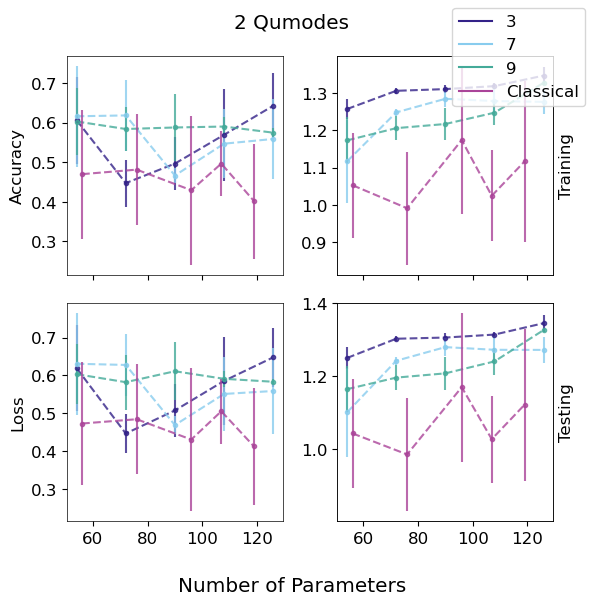

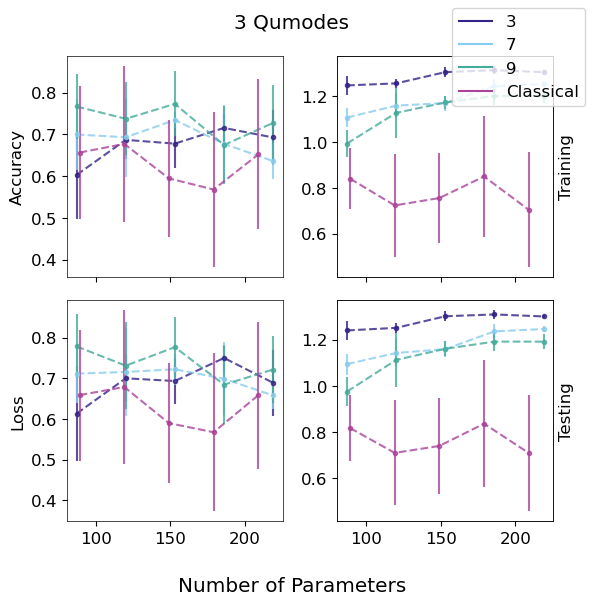

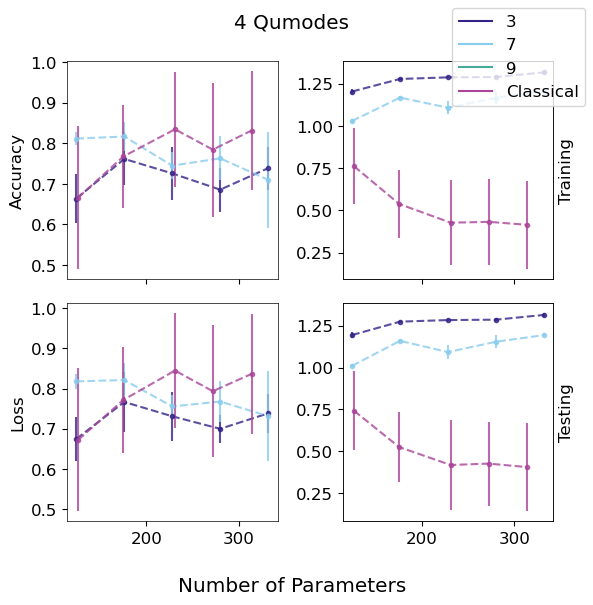

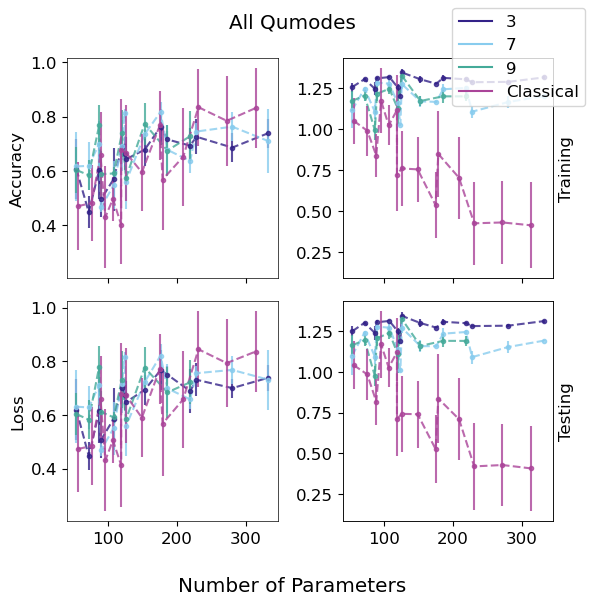

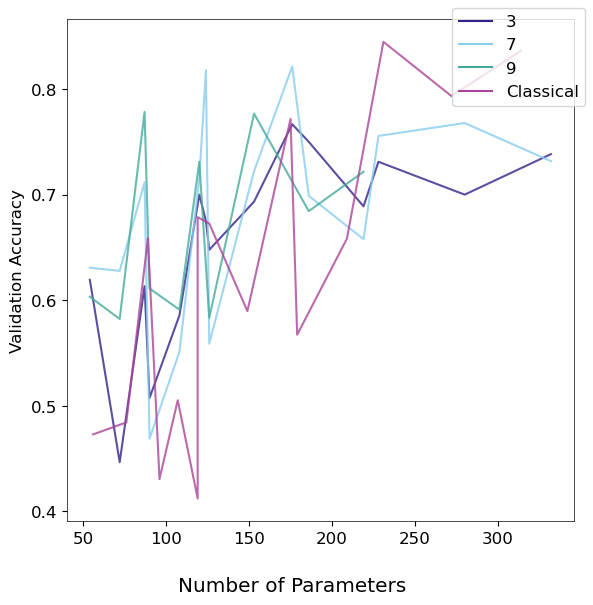

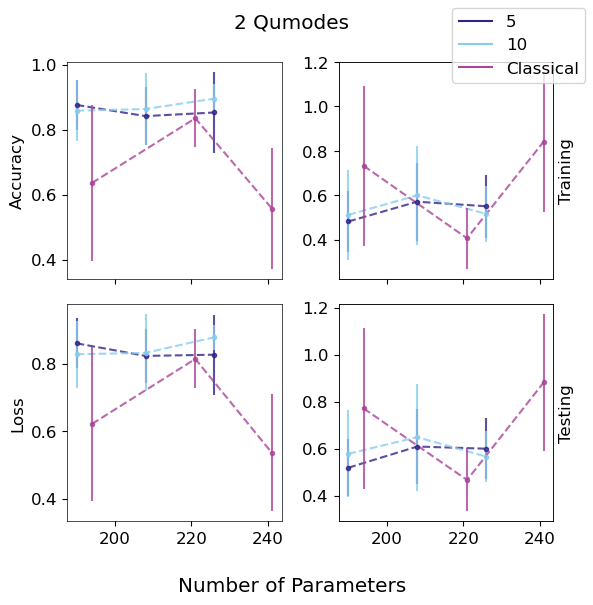

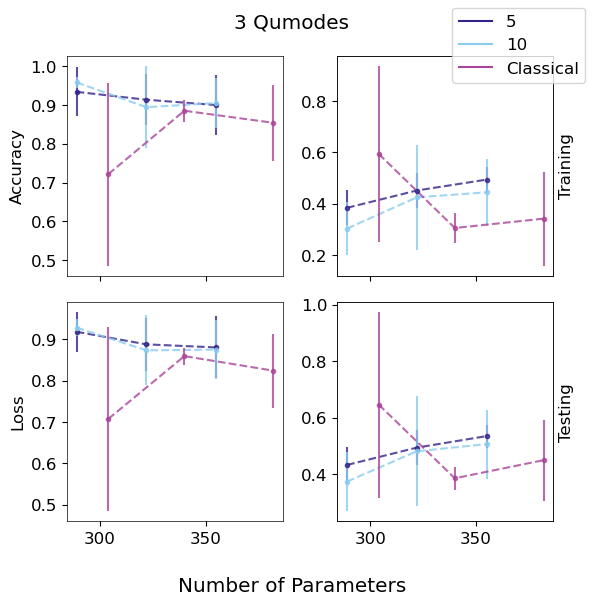

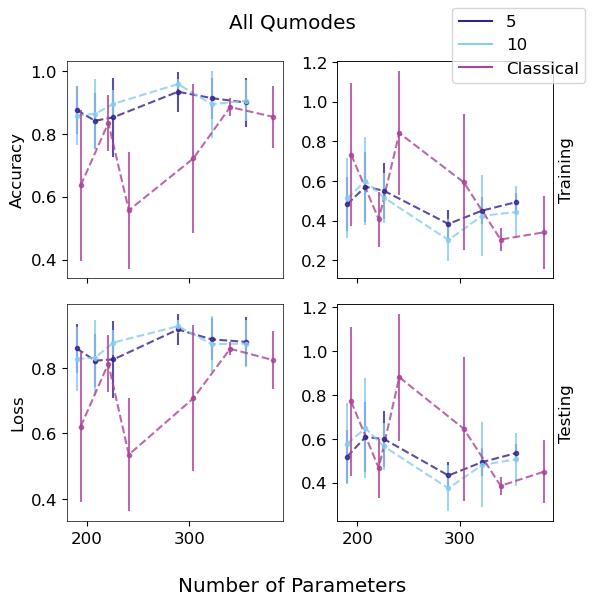

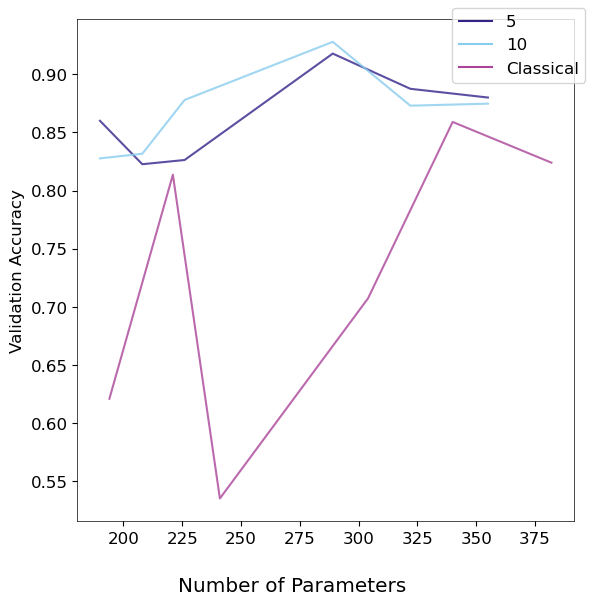

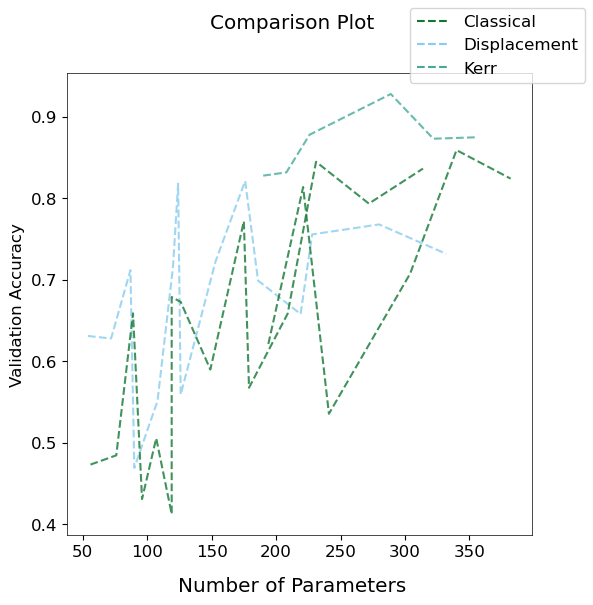

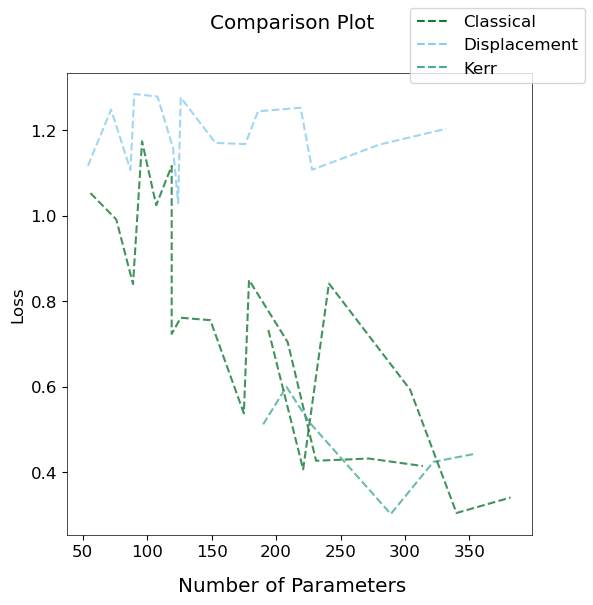

In [27]:

def generate_averaged_database(df):
    df_mean = copy.deepcopy(df)
    df_mean['acc'] = df_mean['acc'].apply(lambda x: x[-1])
    df_mean['acc_std'] = df_mean['acc_std'].apply(lambda x: x[-1])
    df_mean['val_acc'] = df_mean['val_acc'].apply(lambda x: x[-1])
    df_mean['val_acc_std'] = df_mean['val_acc_std'].apply(lambda x: x[-1])
    df_mean['loss'] = df_mean['loss'].apply(lambda x: x[-1])
    df_mean['loss_std'] = df_mean['loss_std'].apply(lambda x: x[-1])
    df_mean['val_loss'] = df_mean['val_loss'].apply(lambda x: x[-1])
    df_mean['val_loss_std'] = df_mean['val_loss_std'].apply(lambda x: x[-1])
    df_mean['acc_ratio'] = df_mean['acc']/df_mean['num_params']
    df_mean['acc_ratio_std'] = df_mean['acc_std']/df_mean['num_params']
    df_mean['val_acc_ratio'] = df_mean['val_acc']/df_mean['num_params']
    df_mean['val_acc_ratio_std'] = df_mean['val_acc_std']/df_mean['num_params']
    df_mean['loss_ratio'] = df_mean['loss']/df_mean['num_params']
    df_mean['loss_ratio_std'] = df_mean['loss_std']/df_mean['num_params']
    df_mean['val_loss_ratio'] = df_mean['val_loss']/df_mean['num_params']
    df_mean['val_loss_ratio_std'] = df_mean['val_loss_std']/df_mean['num_params']
    df_mean.sort_values('num_params')
    return df_mean

def plot_acc_per_param(df, fname='AccPerParam', cutoffs=[3,7,9,'classical']):
    color_dict = dict(zip(cutoffs, colors))
    color_dict['classical'] = colors[-1]
    metrics = ['acc', 'loss', 'val_acc', 'val_loss']
    axs_labels_dict = dict(zip(metrics, ['Accuracy', '', 'Loss']))
    for n in df['num_qumodes'].unique():
        fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True)
        axs_dict = dict(zip(metrics, axs.flatten()))
        for cutoff in cutoffs:
            row = df.loc[(df['num_qumodes']==n) & (df['cutoff']==cutoff)]
            for metric in metrics:
                axs_dict[metric].errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
                axs_dict[metric].plot(row['num_params'].values, row[metric].values, '--', color=color_dict[cutoff], alpha=0.8)


        for key,val in color_dict.items():
            plt.plot([], [], color=val, label=f'{key}'.capitalize())

        ax2  = axs[0,1].twinx()
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        ax2.set_ylabel(f'Training') 
    
        ax2  = axs[1,1].twinx()
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        ax2.set_ylabel(f'Testing')   

        fig.legend()
        fig.supxlabel('Number of Parameters')
        fig.suptitle(f'{n} Qumodes')

        for key, val in axs_labels_dict.items():
            axs_dict[key].set_ylabel(val)
        fig.tight_layout()
        plt.savefig(f'cutoff_sweep_plots/{fname}_AccPerParam_{n}qumodes.png', dpi=300)
        plt.show()


    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True)
    axs_dict = dict(zip(metrics, axs.flatten()))
    for cutoff in cutoffs:
            row = copy.deepcopy(df[(df['cutoff']==cutoff)])
            row.sort_values('num_params', inplace=True)
            for metric in metrics:
                axs_dict[metric].errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
                axs_dict[metric].plot(row['num_params'].values, row[metric].values, '--', color=color_dict[cutoff], alpha=0.8)

    for key,val in color_dict.items():
        plt.plot([], [], color=val, label=f'{key}'.capitalize())

    ax2  = axs[0,1].twinx()
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_ylabel(f'Training') 

    ax2  = axs[1,1].twinx()
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_ylabel(f'Testing')   

    fig.legend()
    fig.supxlabel('Number of Parameters')
    fig.suptitle(f'All Qumodes')
    for key, val in axs_labels_dict.items():
        axs_dict[key].set_ylabel(val)
    fig.tight_layout()
    plt.savefig(f'cutoff_sweep_plots/{fname}_AccPerParam_allqumodes.png', dpi=300)
    plt.show()
    
    
    fig, axs = plt.subplots(figsize=(6,6), sharex=True)
    metric = 'val_acc'
    for cutoff in cutoffs:
        row = copy.deepcopy(df[(df['cutoff']==cutoff)])
        row.sort_values('num_params', inplace=True)
        #axs.errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
        axs.plot(row['num_params'].values, row[metric].values, '-', color=color_dict[cutoff], alpha=0.8)

    for key in cutoffs:
        plt.plot([], [], color=color_dict[key], label=f'{key}'.capitalize()) 

    fig.legend()
    fig.supxlabel('Number of Parameters')
    axs.set_ylabel('Validation Accuracy')
    fig.tight_layout()
    plt.savefig(f'cutoff_sweep_plots/{fname}_AccLarg_allqumodes.png', dpi=300)
    plt.show()


    
    

df_o_mean = generate_averaged_database(df_o)
df_k_mean = generate_averaged_database(df_k)
plot_acc_per_param(df_o_mean, 'cutoff_sweep', cutoffs=[3,7,9,'classical'])
plot_acc_per_param(df_k_mean, 'cutoff_sweep_kerr', cutoffs=[5,10,'classical'])
def plot_comparison(metric, ylabel='Validation Accuracy'):
    fig, axs = plt.subplots(figsize=(6,6), sharex=True)
    color_dict = dict(zip([5,7,10,'classical'], colors))
    for cutoff in [7,'classical']:
        row = copy.deepcopy(df_o_mean[(df_o_mean['cutoff']==cutoff)])
        row.sort_values('num_params', inplace=True)
        #axs.errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
        axs.plot(row['num_params'].values, row[metric].values, '--', color=color_dict[cutoff], alpha=0.8)
        #axs.fill_between(row['num_params'].values, row[metric]-row[f'{metric}_std'], row[metric]+row[f'{metric}_std'], color=color_dict[cutoff], alpha=0.1)
    for cutoff in [10,'classical']:
        row = copy.deepcopy(df_k_mean[(df_k_mean['cutoff']==cutoff)])
        row.sort_values('num_params', inplace=True)
        #axs.errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
        axs.plot(row['num_params'].values, row[metric].values, '--', color=color_dict[cutoff], alpha=0.8)
        #axs.fill_between(row['num_params'].values, row[metric]-row[f'{metric}_std'], row[metric]+row[f'{metric}_std'], color=color_dict[cutoff], alpha=0.1)

    def legend(label, color, linestyle='-', marker=''):
        plt.plot([],[], color=color, ls=linestyle, marker=marker, label=label.capitalize())
        return
    #for key in [5,7,10]:
    #    legend(f'Cutoff {key}', color_dict[key])
    legend('classical', color_dict['classical'], linestyle='--')
    legend('Displacement', color_dict[7], linestyle='--')
    legend('Kerr', color_dict[10], linestyle='--')

    fig.legend()
    fig.supxlabel('Number of Parameters')
    fig.suptitle('Comparison Plot')
    axs.set_ylabel(ylabel)
    #fig.tight_layout()
    plt.show()
plot_comparison('val_acc', 'Validation Accuracy')
plot_comparison('loss', 'Loss')


# Accuracy Violin Plots

,cutoff,iteration,n_layers,num_qumodes,num_params,acc,val_acc,loss,val_loss
cutoff,1.000000,0.479057,-0.338778,NaN,-0.338778,0.315630,0.323812,-0.719411,-0.716896
iteration,0.479057,1.000000,-0.461043,NaN,-0.461043,0.201066,0.207263,-0.410550,-0.406264
n_layers,-0.338778,-0.461043,1.000000,NaN,1.000000,-0.220073,-0.218851,0.503196,0.497397
num_qumodes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_params,-0.338778,-0.461043,1.000000,NaN,1.000000,-0.220073,-0.218851,0.503196,0.497397
acc,0.315630,0.201066,-0.220073,NaN,-0.220073,1.000000,0.978337,-0.455345,-0.451462
val_acc,0.323812,0.207263,-0.218851,NaN,-0.218851,0.978337,1.000000,-0.450336,-0.446976
loss,-0.719411,-0.410550,0.503196,NaN,0.503196,-0.455345,-0.450336,1.000000,0.999579
val_loss,-0.716896,-0.406264,0.497397,NaN,0.497397,-0.451462,-0.446976,0.999579,1.000000


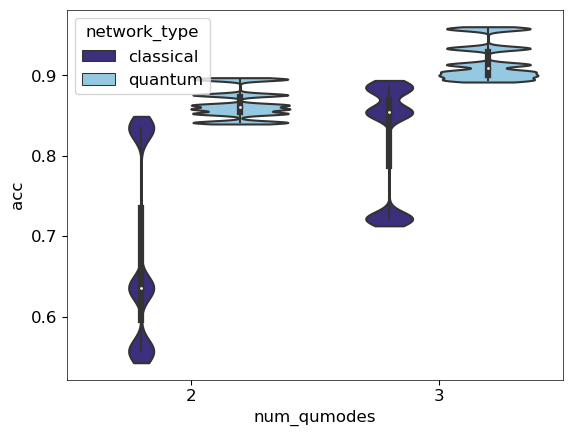

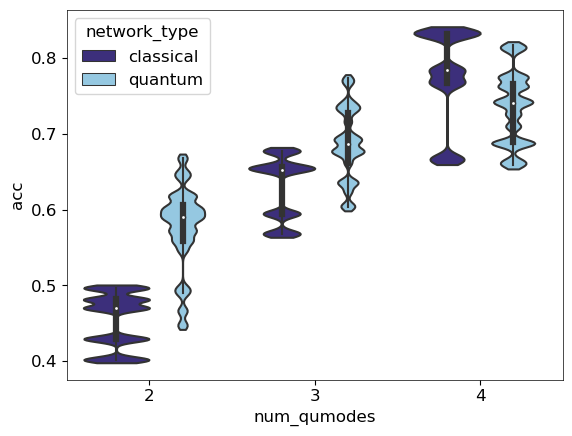

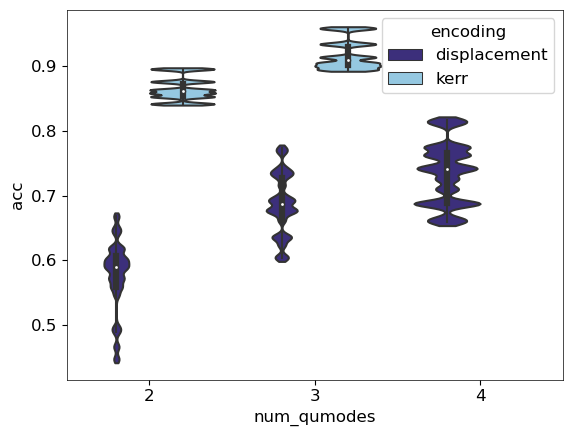

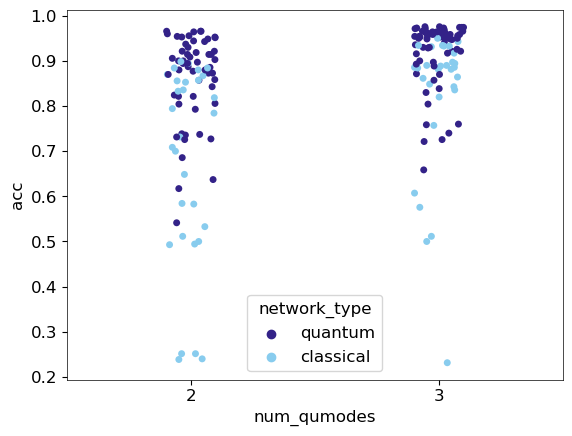

<Axes: xlabel='num_qumodes', ylabel='acc'>

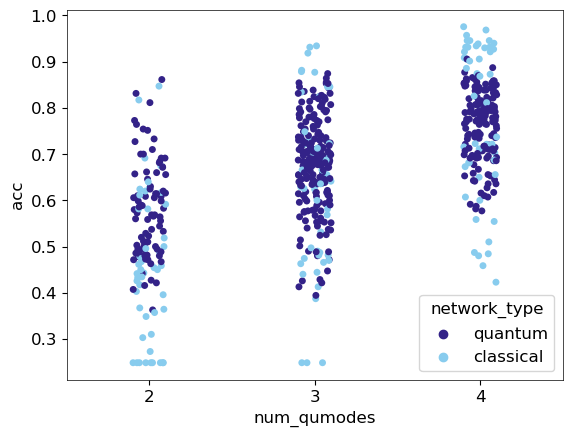

In [28]:
def pd_last_epoch(df):
    df_out = copy.deepcopy(df)
    df_out['acc'] = df_out['acc'].apply(lambda x: x[-1])
    df_out['val_acc'] = df_out['val_acc'].apply(lambda x: x[-1])
    df_out['loss'] = df_out['loss'].apply(lambda x: x[-1])
    df_out['val_loss'] = df_out['val_loss'].apply(lambda x: x[-1])
    return df_out

encodings = {'displacement': df_orig, 'kerr': df_kerr}
df_full = pd.concat(encodings, names=['encoding'])
df_full = df_full.reset_index(level=0)
df_f_stat = pd_last_epoch(df_full)
pd.to_pickle(df_full, 'df_full.pkl')
df_f = process_data(df_full, groups=['network_type', 'n_layers', 'num_qumodes', 'num_params', 'cutoff', 'encoding'])
df_f_mean = generate_averaged_database(df_f)
df_o_stat = pd_last_epoch(df_orig)
df_k_stat = pd_last_epoch(df_kerr)
df_f_stat_quantum = copy.deepcopy(df_f_stat[df_f_stat['network_type'] == 'quantum'])
df_f_stat_quantum['cutoff'] = df_f_stat_quantum['cutoff'].apply(pd.to_numeric)
df_o_stat_quantum = copy.deepcopy(df_o_stat[df_o_stat['network_type'] == 'quantum'])
df_o_stat_quantum['cutoff'] = df_o_stat_quantum['cutoff'].apply(pd.to_numeric)
df_k_stat_quantum = copy.deepcopy(df_k_stat[df_k_stat['network_type'] == 'quantum'])
df_k_stat_quantum['cutoff'] = df_k_stat_quantum['cutoff'].apply(pd.to_numeric)
display(df_o_stat_quantum[df_o_stat_quantum['num_qumodes']==4].corr())
sns.violinplot(df_k_mean, x='num_qumodes', y='acc', hue='network_type', split=False, cut=True, bw=0.1)
plt.show()
sns.violinplot(df_o_mean, x='num_qumodes', y='acc', hue='network_type', split=False, cut=True, bw=0.1)
plt.show()
sns.violinplot(df_f_mean[df_f_mean['network_type']=='quantum'], x='num_qumodes', y='acc', hue='encoding', split=False, cut=True, bw=0.1)
plt.show()

sns.stripplot(df_k_stat, x='num_qumodes', y='acc', hue='network_type')
plt.show()
sns.stripplot(df_o_stat, x='num_qumodes', y='acc', hue='network_type')

/home/st4eve/miniconda3/envs/CVTrain/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/st4eve/miniconda3/envs/CVTrain/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/st4eve/miniconda3/envs/CVTrain/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean

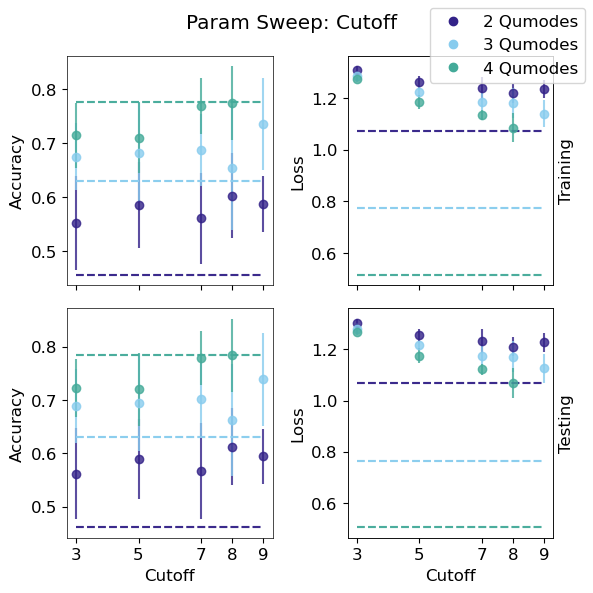

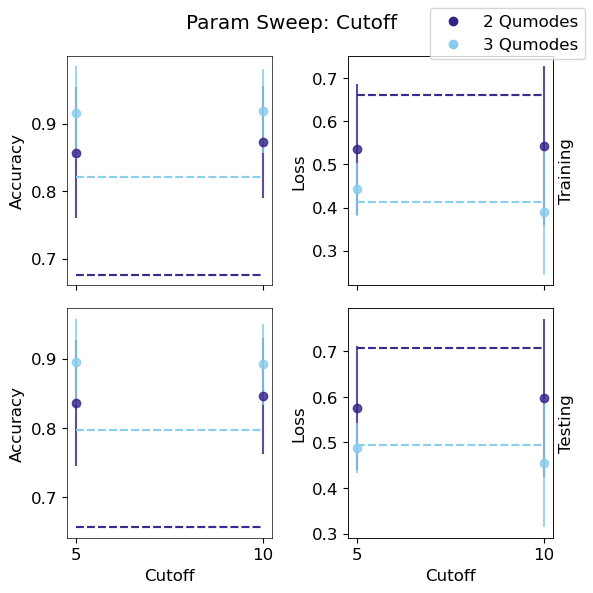

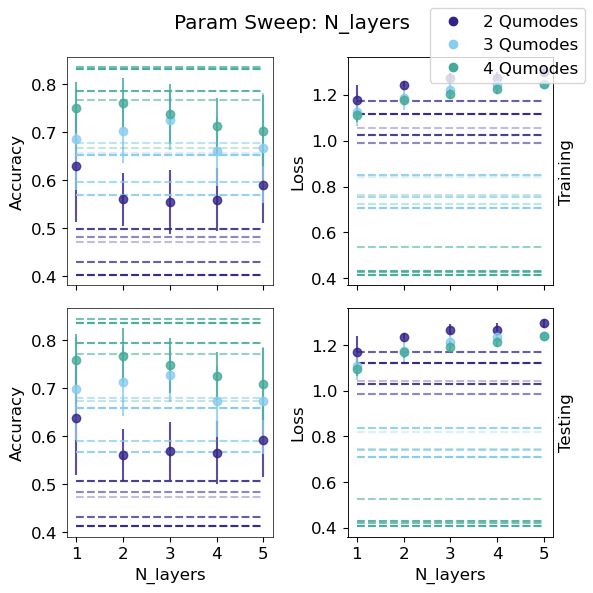

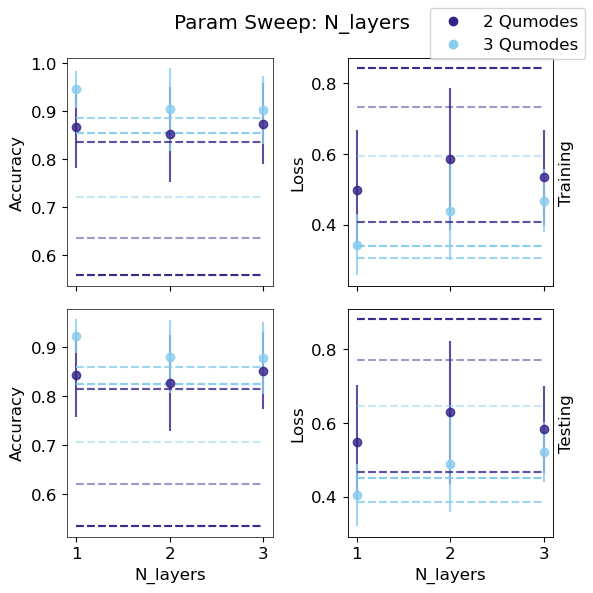

In [29]:
def plot_param_sweep(df, param='cutoff', fname='cutoff_sweep'):    
    df_cutoff = df[df['network_type']=='quantum'].groupby([param, 'num_qumodes']).apply(np.mean)
    df_cutoff[param] = df_cutoff[param].apply(int)
    df_classical = df[df['network_type']=='classical'].groupby([param, 'num_qumodes']).apply(np.mean)

    color_dict = dict(zip(df['num_qumodes'].unique(), colors))
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True)
    axs[0,0].set_ylabel('Accuracy')
    axs[1,0].set_ylabel('Accuracy')
    axs[0,1].set_ylabel('Loss')
    axs[1,1].set_ylabel('Loss')

    axs[1,0].set_xlabel(param.capitalize())
    axs[1,1].set_xlabel(param.capitalize())

    axs[0,0].set_xticks(df_cutoff[param].unique(), df_cutoff[param].unique())
    axs_dict = dict(zip(['acc', 'loss', 'val_acc', 'val_loss'], axs.flatten()))
    for i, row in df_cutoff.iterrows():
        for metric in ['acc', 'loss', 'val_acc', 'val_loss']:
            axs_dict[metric].errorbar(row[param], row[metric], yerr=row[f'{metric}_std'], fmt='o', color=color_dict[row['num_qumodes']], alpha=0.8)

    if param == 'n_layers':
        alpha = lambda x: 0.8*(x/df_classical[param].unique()[-1])
        for i, row in df_classical.iterrows():
            for metric in ['acc', 'loss', 'val_acc', 'val_loss']:
                axs_dict[metric].hlines([row[metric], row[metric]], df_cutoff[param].unique()[0], df_cutoff[param].unique()[-1], ls='--', color=color_dict[row['num_qumodes']], alpha=alpha(row[param]))
    else:
         for i, row in df_classical.iterrows():
            for metric in ['acc', 'loss', 'val_acc', 'val_loss']:
                axs_dict[metric].hlines([row[metric], row[metric]], df_cutoff[param].unique()[0], df_cutoff[param].unique()[-1], ls='--', color=color_dict[row['num_qumodes']], alpha=0.8)


    for key,val in color_dict.items():
        plt.plot([], [], marker='o', lw=0 , color=val, label=f'{key} Qumodes')

    ax2  = axs[0,1].twinx()
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_ylabel(f'Training') 

    ax2  = axs[1,1].twinx()
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_ylabel(f'Testing')   
    fig.suptitle(f'Param Sweep: {param.capitalize()}')

    fig.legend()
    fig.tight_layout()

plot_param_sweep(df_o_mean, param='cutoff', fname='cutoff_sweep')
plot_param_sweep(df_k_mean, param='cutoff', fname='cutoff_sweep_kerr')
plot_param_sweep(df_o_mean, param='n_layers', fname='n_layers_sweep')
plot_param_sweep(df_k_mean, param='n_layers', fname='n_layers_sweep_kerr')

# Generate timing plots

,cutoff,n_layers,network_type,num_qumodes,time
49,8,3,quantum,3,29.434219
181,1,1,quantum,2,4.069443
700,1,4,quantum,4,35.732792
363,0,3,classical,3,0.013893
242,5,4,quantum,3,30.103796


,cutoff,n_layers,num_qumodes,time
count,558.000000,558.000000,558.000000,558.000000
mean,3.539427,2.931900,2.903226,15.885501
std,3.240407,1.461297,0.826811,17.804718
min,0.000000,1.000000,2.000000,0.007966
25%,0.000000,2.000000,2.000000,0.011081
50%,3.000000,3.000000,3.000000,10.519551
75%,7.000000,4.000000,4.000000,23.889029
max,9.000000,5.000000,4.000000,104.721803


,n_layers,num_qumodes,cutoff,time
count,96.000000,96.000000,96.000000,96.000000
mean,2.989583,2.906250,4.354167,18.474746
std,1.417892,0.795754,3.168859,17.625072
min,1.000000,2.000000,0.000000,0.008571
25%,2.000000,2.000000,1.000000,6.640710
50%,3.000000,3.000000,5.000000,14.680156
75%,4.000000,4.000000,7.000000,25.449163
max,5.000000,4.000000,9.000000,101.984397


,cutoff,n_layers,network_type,num_qumodes,time
49,5,1,quantum,2,4.474238
181,0,2,classical,2,0.002547
242,0,2,classical,4,0.002853
52,10,1,quantum,3,20.026088
27,10,1,quantum,2,7.431744


,n_layers,num_qumodes,time
count,253.000000,253.000000,253.000000
mean,2.565217,2.774704,6.272804
std,1.315617,0.756344,9.554437
min,1.000000,2.000000,0.001641
25%,1.000000,2.000000,0.002629
50%,2.000000,3.000000,0.002980
75%,3.000000,3.000000,10.215891
max,5.000000,4.000000,49.405092


,n_layers,num_qumodes,cutoff,time
count,27.000000,27.000000,27.000000,27.000000
mean,2.555556,2.777778,3.333333,7.402053
std,1.310705,0.751068,4.160251,10.299950
min,1.000000,2.000000,0.000000,0.002528
25%,1.500000,2.000000,0.000000,0.002723
50%,2.000000,3.000000,0.000000,0.002836
75%,3.000000,3.000000,5.000000,12.308775
max,5.000000,4.000000,10.000000,33.832750


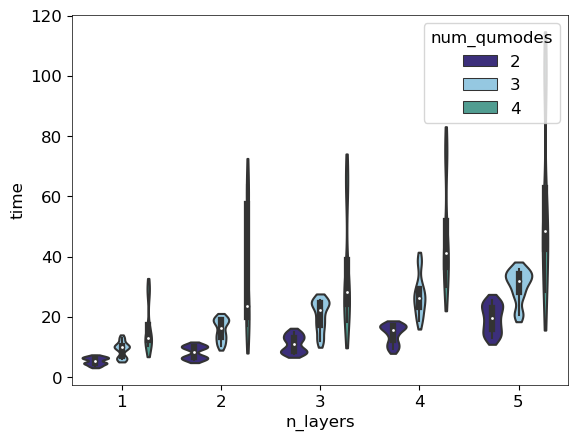

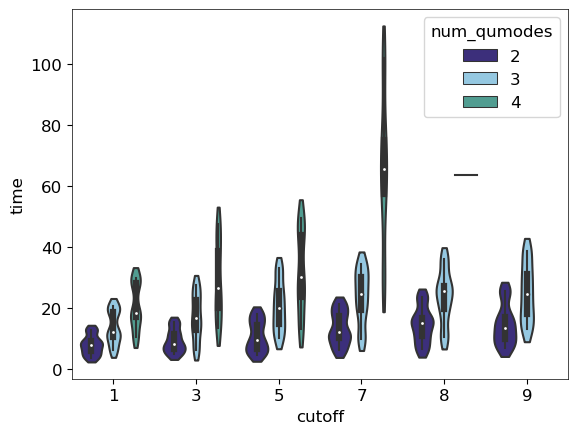

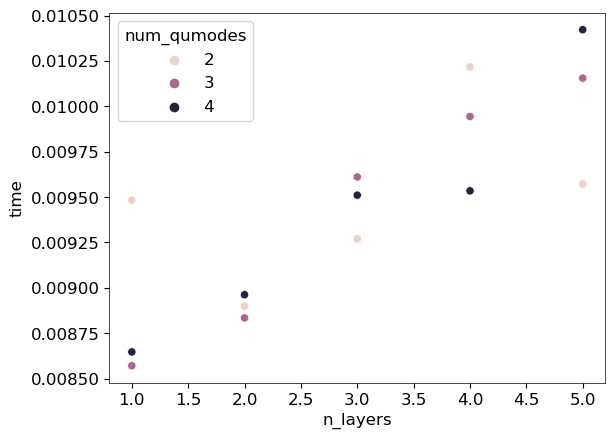

Correlation Matrix


,n_layers,num_qumodes,cutoff,time
n_layers,1.000000,-0.010204,-0.008541,0.368124
num_qumodes,-0.010204,1.000000,-0.157845,0.463521
cutoff,-0.008541,-0.157845,1.000000,0.439424
time,0.368124,0.463521,0.439424,1.000000


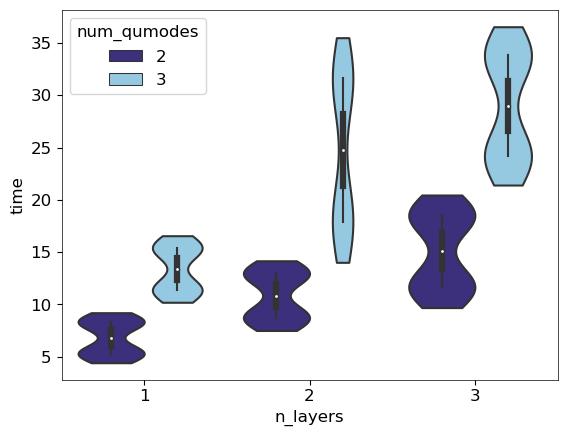

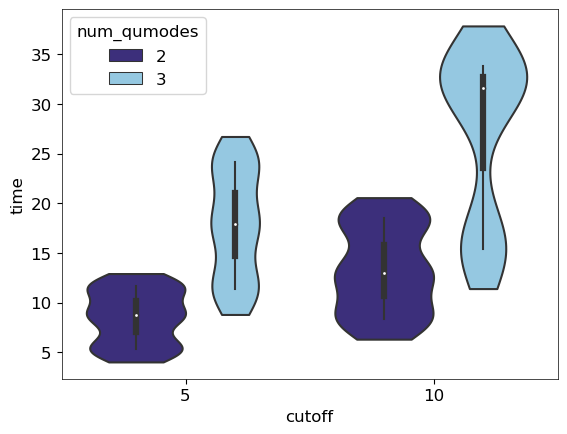

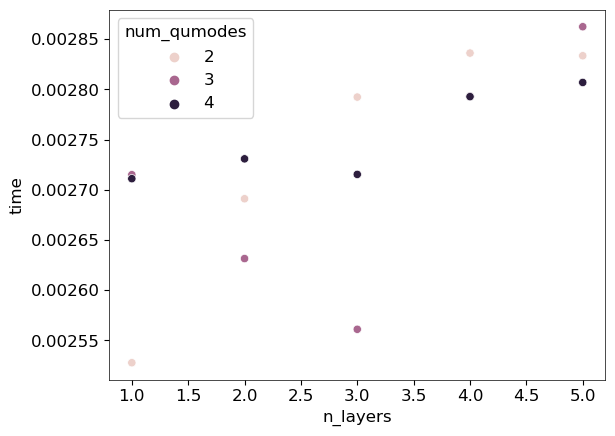

Correlation Matrix


,n_layers,num_qumodes,cutoff,time
n_layers,1.000000,0.130233,-0.352673,-0.180184
num_qumodes,0.130233,1.000000,-0.307729,-0.104796
cutoff,-0.352673,-0.307729,1.000000,0.840661
time,-0.180184,-0.104796,0.840661,1.000000


In [12]:
from common_packages.calc_time import calc_time, generate_time_database, calc_time_per_epoch, find_max_time
import seaborn as sns
def generate_time_df(ex_path):
    time_data = generate_time_database(ex_path) 
    df_time = pd.DataFrame(columns=time_data[1]['config'].keys())
    df_time['time'] = np.nan
    df_time.pop('__doc__')
    for exp, val in time_data.items():
        config = val['config']
        config.pop('__doc__', None)
        if config['iteration'] != -1:
            time = val['time']
            df_time.loc[exp] = [*config.values(), time] 
    df_time.pop('iteration')
    df_time.loc[df_time['network_type']=='classical', 'cutoff'] = 0
    df_time['time'] = df_time['time'] / np.timedelta64(1,'h')
    df_time_mean = df_time.groupby(['network_type', 'n_layers', 'num_qumodes', 'cutoff']).mean()
    df_time_mean.reset_index(inplace=True)
    display(df_time.head())
    # display(df_time_mean.head())
    display(df_time.describe())
    display(df_time_mean.describe())
    return df_time, df_time_mean

df_time_orig, df_time_mean_orig = generate_time_df('/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep')
df_time_kerr, df_time_mean_kerr = generate_time_df('/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Kerr')

def plot_time_violin(df, fname='time_violin'):
    sns.violinplot(df[df['network_type']=='quantum'], x='n_layers', hue='num_qumodes', y='time', bw=0.4, cut=True)
    plt.show()
    sns.violinplot(df[df['network_type']=='quantum'], hue='num_qumodes', x='cutoff', y='time', bw=0.4, cut=True)
    plt.show()
    sns.scatterplot(df[df['network_type']=='classical'], hue='num_qumodes', x='n_layers', y='time')
    plt.show()
    print('Correlation Matrix')
    display(df.corr())

plot_time_violin(df_time_mean_orig, 'time_violin_orig')
plot_time_violin(df_time_mean_kerr, 'time_violin_kerr')



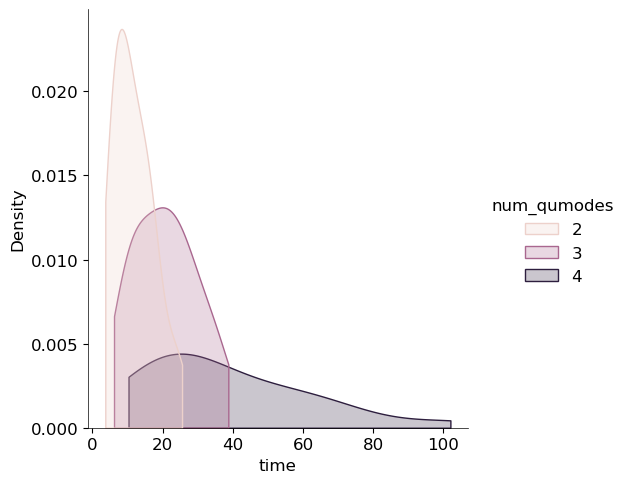

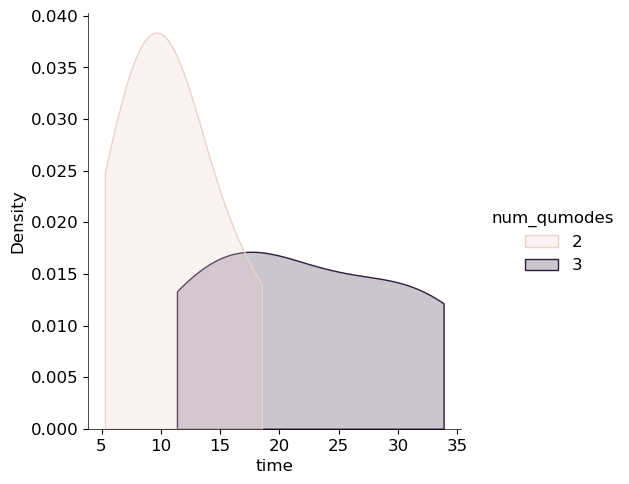

In [10]:
sns.displot(df_time_mean_orig[df_time_mean_orig['network_type']=='quantum'], x='time', hue='num_qumodes', kind='kde', cut=0, fill=True)
sns.displot(df_time_mean_kerr[df_time_mean_kerr['network_type']=='quantum'], x='time', hue='num_qumodes', kind='kde', cut=0, fill=True)

4    [0.3285714387893677, 0.404285728931427, 0.3785...
7    [0.334285706281662, 0.27142858505249023, 0.255...
2    [0.345714271068573, 0.3985714316368103, 0.4185...
Name: acc, dtype: object

classical 2 5 (0, 0)
quantum 2 5 (0, 0)
classical 2 10 (0, 1)
quantum 2 10 (0, 1)
classical 3 5 (1, 0)
quantum 3 5 (1, 0)
classical 3 10 (1, 1)
quantum 3 10 (1, 1)
classical 4 5 (2, 0)
quantum 4 5 (2, 0)
classical 4 10 (2, 1)


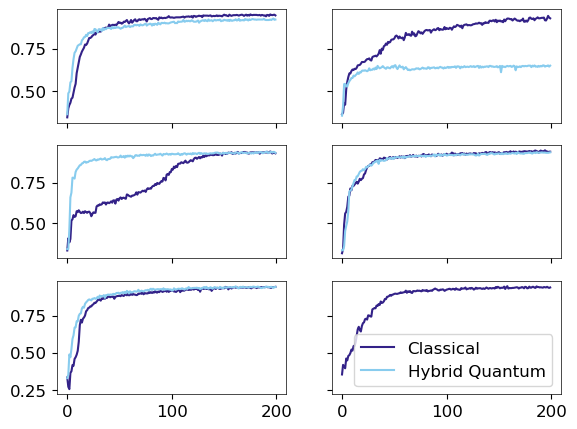

In [11]:
ex_path = "Synthetic_Hybrid_Base_Experiment_Cutoff10"

dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[1]['config']
config.pop('__doc__', None)
#config.pop('iteration', None)
df = pd.DataFrame(columns=config.keys())
df['acc'] = np.nan
df['val_acc'] = np.nan
df['loss'] = np.nan
df['val_loss'] = np.nan
for i in data.keys():
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss, val_acc, val_loss = metrics.values()
    acc = np.array(acc)
    loss = np.array(loss)
    val_acc = np.array(val_acc)
    val_loss = np.array(val_loss)
    df.loc[i] = [*config.values(), acc, val_acc, loss, val_loss]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(6.5, 5), sharey='row', sharex='col')
df.sort_values('network_type',inplace=True)
display(df[(df['network_type']=='classical') & (df['cutoff']==5)]['acc'])
num_qumodes = [2,3,4]
cutoff_dims = [5,10]
network_types = ['classical', 'quantum']

for i,qumodes in enumerate(num_qumodes):
    for j,cutoff in enumerate(cutoff_dims):
        for net_type in network_types:
            for n,row in df[(df['network_type']==net_type) & (df['cutoff']==cutoff) & (df['num_qumodes']==qumodes)].iterrows():
                print(net_type, qumodes, cutoff, (i,j))
                axs[i,j].plot(row['acc'])

plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
plt.legend()

In [12]:

ex_path = "Synthetic_Hybrid_PWB_Experiment_Test2"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[6]['config']
config.pop('__doc__', None)
df = pd.DataFrame(columns=config.keys())
df['avg_acc'] = np.nan
df['acc_err'] = np.nan
df['avg_loss'] = np.nan
df['loss_err'] = np.nan
for i in range(1, len(data) + 1):
    try:
        config = data[i]['config']
        config.pop('__doc__', None)
        metrics = data[i]['metrics']
        metrics.pop('epoch',None)
        acc, loss = metrics.values()
        avg_acc = np.mean(acc)
        acc_err = np.std(acc)
        avg_loss = np.mean(loss)
        loss_err = np.std(loss)
        df.loc[i] = [*config.values(), avg_acc, acc_err, avg_loss, loss_err]
    except KeyError:
        print(f"Invalid: {i}")
   
x = np.array(df['sigma'].unique()).astype(float)
x = np.log2(1+1/x)
plot_df = pd.DataFrame(index=x)
df = df.sort_values('sigma')


FileNotFoundError: [Errno 2] No such file or directory: 'Synthetic_Hybrid_PWB_Experiment_Test2'

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6, 5), sharex='col', sharey='row')


for i in range(2,5):


    mask = (df['network_type']=='quantum') & (df['num_qumodes']==i)

    x1 = np.array(df[mask]['sigma'].unique()).astype(float)
    x1 = np.log2(1+1/x1)

    acc_q = df[mask]['avg_acc']
    acc_err_q = df[mask]['acc_err']
    loss_q = df[mask]['avg_loss']
    loss_err_q = df[mask]['loss_err']

    mask = (df['network_type']=='classical') & (df['num_qumodes']==i)

    x2 = np.array(df[mask]['sigma'].unique()).astype(float)
    x2 = np.log2(1+1/x2)
    
    acc_c = df[mask]['avg_acc']
    acc_err_c = df[mask]['acc_err']
    loss_c = df[mask]['avg_loss']
    loss_err_c = df[mask]['loss_err']    

    #ax[i-2].grid(True, linestyle=':')
    line_q = ax[i-2].plot(x1, acc_q, alpha=0.8)
    ax[i-2].fill_between(x1, acc_q - acc_err_q, acc_q + acc_err_q, interpolate=True, alpha=0.2)
    
    line_c = ax[i-2].plot(x2, acc_c, alpha=0.8)
    ax[i-2].fill_between(x2, acc_c - acc_err_c, acc_c + acc_err_c, interpolate=True, alpha=0.2)
    ax[i-2].set_title(f'{i} Qumode')
    ax[i-2].hlines(0.9, 0, 10, linestyles='--', color=colors[6]) 
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.supylabel('Accuracy')
fig.supxlabel('Precision (Bits)')
fig.suptitle('Synthetic Data Accuracy Comparison')
plt.savefig(f'../Plotting/Synthetic_comparison.pdf')
plt.show()

In [ ]:
%matplotlib inline

for i in range(1, len(data) + 1):
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss = metrics.values()
    avg_acc = np.mean(acc)
    acc_err = np.std(acc)
    avg_loss = np.mean(loss)
    loss_err = np.std(loss)
    df.loc[i] = [*config.values(), avg_acc, acc_err, avg_loss, loss_err]
   
    
df = df.sort_values('sigma')
x = np.array(df['sigma'].unique()).astype(float)
x = np.log2(1+1/x)
plot_df = pd.DataFrame(index=x)

mask = (df['network_type']=='quantum') & (df['num_qumodes']==4)
acc_q = df[mask]['avg_acc']
acc_err_q = df[mask]['acc_err']
loss_q = df[mask]['avg_loss']
loss_err_q = df[mask]['loss_err']

mask = (df['network_type']=='classical') & (df['num_qumodes']==4)

acc_c = df[mask]['avg_acc']
acc_err_c = df[mask]['acc_err']
loss_c = df[mask]['avg_loss']
loss_err_c = df[mask]['loss_err']

plot_df['Ph Q Acc 4'] = acc_q.values
plot_df['Ph Q Acc Err 4'] = acc_err_q.values
plot_df['Ph Q Loss 4'] = loss_q.values
plot_df['Ph Q Loss Err 4'] = loss_err_q.values
plot_df['Ph C Acc 4'] = acc_c.values
plot_df['Ph C Acc Err 4'] = acc_err_c.values
plot_df['Ph C Loss 4'] = loss_c.values
plot_df['Ph C Loss Err 4'] = loss_err_c.values

Plot = MultiPlot([x,x], 
                 [acc_q, acc_c],
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=['Quantum', 'Classical'], 
                 yerr=[acc_err_q, acc_err_c],
                 title='All Photonic 4 Qumode',
                 legend_position_x=0.5,
                 legend_position_y=-0.02)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()


In [ ]:
mask = (df['network_type']=='quantum') & (df['num_qumodes']==4)

acc_q = df[mask]['avg_acc']
acc_err_q = df[mask]['acc_err']
loss_q = df[mask]['avg_loss']
loss_err_q = df[mask]['loss_err']

mask = (df['network_type']=='classical') & (df['num_qumodes']==4)

acc_c = df[mask]['avg_acc']
acc_err_c = df[mask]['acc_err']
loss_c = df[mask]['avg_loss']
loss_err_c = df[mask]['loss_err']


plot_df['TF Q Acc 4'] = acc_q.values
plot_df['TF Q Acc Err 4'] = acc_err_q.values
plot_df['TF Q Loss 4'] = loss_q.values
plot_df['TF Q Loss Err 4'] = loss_err_q.values
plot_df['TF C Acc 4'] = acc_c.values
plot_df['TF C Acc Err 4'] = acc_err_c.values
plot_df['TF C Loss 4'] = loss_c.values
plot_df['TF C Loss Err 4'] = loss_err_c.values

Plot = MultiPlot([x,x], 
                 [acc_q, acc_c],
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=['Quantum', 'Classical'], 
                 yerr=[acc_err_q, acc_err_c],
                 title='Digital 4 Qumode',
                 legend_position_x=0.5,
                 legend_position_y=-0.02)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()

In [ ]:
mask = (df['network_type']=='quantum') & (df['num_qumodes']==3)

acc_q = df[mask]['avg_acc']
acc_err_q = df[mask]['acc_err']
loss_q = df[mask]['avg_loss']
loss_err_q = df[mask]['loss_err']

mask = (df['network_type']=='classical') & (df['num_qumodes']==3)

acc_c = df[mask]['avg_acc']
acc_err_c = df[mask]['acc_err']
loss_c = df[mask]['avg_loss']
loss_err_c = df[mask]['loss_err']

plot_df['Ph Q Acc 3'] = acc_q.values
plot_df['Ph Q Acc Err 3'] = acc_err_q.values
plot_df['Ph Q Loss 3'] = loss_q.values
plot_df['Ph Q Loss Err 3'] = loss_err_q.values
plot_df['Ph C Acc 3'] = acc_c.values
plot_df['Ph C Acc Err 3'] = acc_err_c.values
plot_df['Ph C Loss 3'] = loss_c.values
plot_df['Ph C Loss Err 3'] = loss_err_c.values

fig = plt.figure(
        figsize= (
                8,4))

Plot = MultiPlot([x,x], 
                 [acc_q, acc_c],
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=['Quantum', 'Classical'], 
                 yerr=[acc_err_q, acc_err_c],
                 title='All Photonic 3 Qumode',
                 legend_position_x=0.5,
                 legend_position_y=-0.02)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()

In [ ]:
names = ['Ph C Acc 4', 'Ph Q Acc 4']
names_err = [n.split(' ') for n in names]
[names_err[i].insert(-1, 'Err') for i,n in enumerate(names_err)]
names_err = [" ".join(names_err[i]) for i,n in enumerate(names_err)]

Plot = MultiPlot([plot_df.index for i in names], 
                 plot_df[names].values.T,
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=[*names], 
                 yerr=plot_df[names_err].values.T,
                 title='Network Comparison 4 Qumode',
                 legend_position_x=0.45,
                 legend_position_y=0.0)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()

In [ ]:
names = ['Ph C Acc 3', 'Ph Q Acc 3']
names_err = [n.split(' ') for n in names]
[names_err[i].insert(-1, 'Err') for i,n in enumerate(names_err)]
names_err = [" ".join(names_err[i]) for i,n in enumerate(names_err)]

Plot = MultiPlot([plot_df.index for i in names], 
                 plot_df[names].values.T,
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=[*names], 
                 yerr=plot_df[names_err].values.T,
                 title='Network Comparison 3 Qumode',
                 legend_position_x=0.6,
                 legend_position_y=0.0)
Plot.options["figure_size_x"] = 12
Plot.options["figure_size_y"] = 8
Plot.plot()

In [ ]:
%matplotlib inline
from common_packages.CV_quantum_layers import Activation_Layer, CV_Measurement, QuantumLayer_MultiQunode
from PWBLayer_TF import PWBLinearLayer
from keras import Model, layers, models, regularizers
from common_packages.utilities import get_equivalent_classical_layer_size
from hybrid_base import EXPERIMENT_NAME as BASE_EXPERIMENT_NAME
from hybrid_base import LOSS_FUNCTION, NUM_EPOCHS, OPTIMIZER, RANDOM_SEED
import tensorflow as tf
from data import generate_synthetic_dataset
import copy
import json
from os import listdir
from os.path import isdir, join
from hybrid_pwb import get_config
from sklearn.metrics import ConfusionMatrixDisplay

network_type = 'classical'
num_qumodes = 4

class Net(Model):  # pylint: disable=W0223
        """Neural network model to train on"""

        def __init__(self):
            self._estimator_type='classifier'
            super().__init__()
            precision = int(2**15 - 1)
            self.base_model = models.Sequential(
                [
                    layers.Dense(20, activation="relu"),
                    layers.Dense(20, activation="relu"),
                    layers.Dense(2*num_qumodes, activation=None),
                ]
            )

            if network_type == "classical":
                self.quantum_substitue = models.Sequential(
                    [
                        layers.Dense(
                            get_equivalent_classical_layer_size(num_qumodes, 2 * num_qumodes, 3),
                            activation="relu",
                            bias_constraint=lambda t: tf.clip_by_value(t, -1.0, 1.0),
                            kernel_constraint=lambda t: tf.clip_by_value(t, -1.0, 1.0),
                        ),
                    ]
                )

            self.quantum_layer = QuantumLayer_MultiQunode(
                n_qumodes=num_qumodes,
                n_circuits=1,
                n_layers=1,
                cutoff_dim=3,
                encoding_method="Amplitude_Phase",
                regularizer=regularizers.L1(l1=0.1),
                max_initial_weight=0.15,
                measurement_object=CV_Measurement("X_quadrature"),
                shots=None,
            )

            self.quantum_preparation_layer = Activation_Layer("Sigmoid", self.quantum_layer.encoding_object)

            self.final_layer = models.Sequential([layers.Dense(3, activation="softmax")])

        def call(self, inputs):  # pylint: disable=W0221
            """Call the network"""
            output = self.base_model(inputs)
            if network_type == "quantum":
                output = self.quantum_preparation_layer(output)
                output = self.quantum_layer(output)
            elif network_type == "classical":
                output = self.quantum_substitue(output)
            else:
                raise ValueError("Invalid network type specified.")
            output = self.final_layer(output)
            output = tf.argmax(output, axis=1)
            return output

_, validate_data = generate_synthetic_dataset()
model = Net()
model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=["accuracy"])
sub_folders = [folder for folder in listdir(BASE_EXPERIMENT_NAME) if isdir(join(BASE_EXPERIMENT_NAME, folder))]
experiment_numbers = [sub_folder for sub_folder in sub_folders if sub_folder.isdigit()]
target_experiment_path_list = []
predictions = []
for experiment_num in experiment_numbers:
    config = get_config(f"{BASE_EXPERIMENT_NAME}/{experiment_num}")
    if config["num_qumodes"] == num_qumodes and config["network_type"] == network_type:
        target_experiment_path_list.append(f"{BASE_EXPERIMENT_NAME}/{experiment_num}")

target_experiment_path = target_experiment_path_list[0]
model.load_weights(f"{target_experiment_path}/weights/weight{NUM_EPOCHS-1}.ckpt", by_name=False)

x = validate_data[0]
y = tf.argmax(validate_data[1], axis=-1)
fig = plt.figure(figsize=(1,1))
ConfusionMatrixDisplay.from_estimator(model, X=x, y=y)
plt.savefig('Synthetic_Confusion.pdf')
plt.show()

For Number of Qumodes:  2  Cutoff:  5  Layers:  1
Highest Accuracy Experiments
Quantum: 25 
Classical: 156
10/10 [==============================] - 0s 3ms/step - loss: 0.4639 - accuracy: 0.8533
Average Maximum Output Probability
Quantum: 0.7200173139572144
Classical: 0.7444879412651062


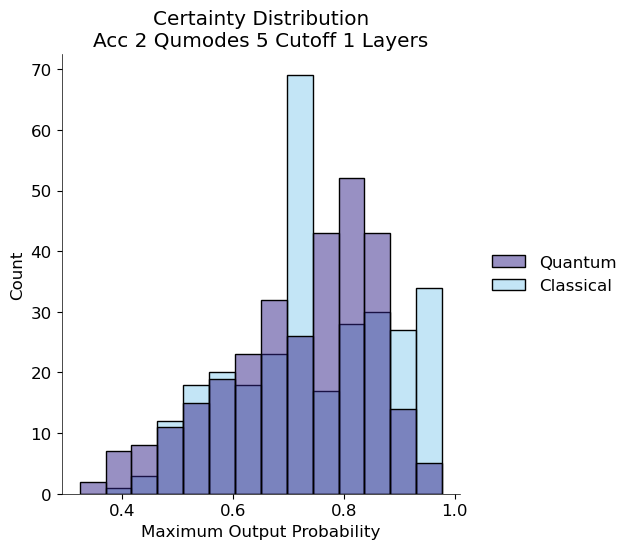

For Number of Qumodes:  2  Cutoff:  5  Layers:  2
Highest Accuracy Experiments
Quantum: 88 
Classical: 227
10/10 [==============================] - 0s 3ms/step - loss: 0.4304 - accuracy: 0.8667
Average Maximum Output Probability
Quantum: 0.8279951214790344
Classical: 0.7618494629859924


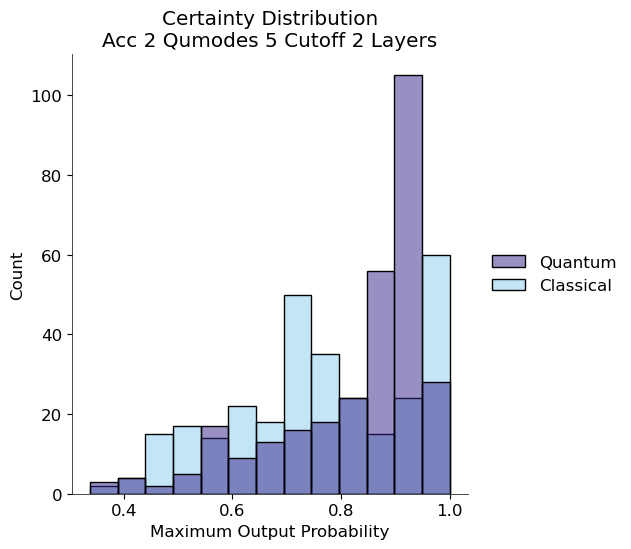

For Number of Qumodes:  2  Cutoff:  5  Layers:  3
Highest Accuracy Experiments
Quantum: 106 
Classical: 142
10/10 [==============================] - 0s 2ms/step - loss: 0.4538 - accuracy: 0.8167
Average Maximum Output Probability
Quantum: 0.6147007346153259
Classical: 0.7404360175132751


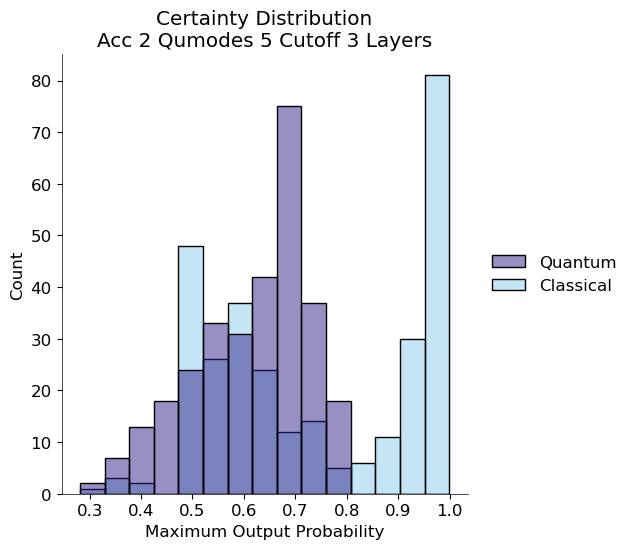

For Number of Qumodes:  2  Cutoff:  10  Layers:  1
Highest Accuracy Experiments
Quantum: 75 
Classical: 156
10/10 [==============================] - 0s 2ms/step - loss: 0.4639 - accuracy: 0.8533
Average Maximum Output Probability
Quantum: 0.6197118163108826
Classical: 0.7444879412651062


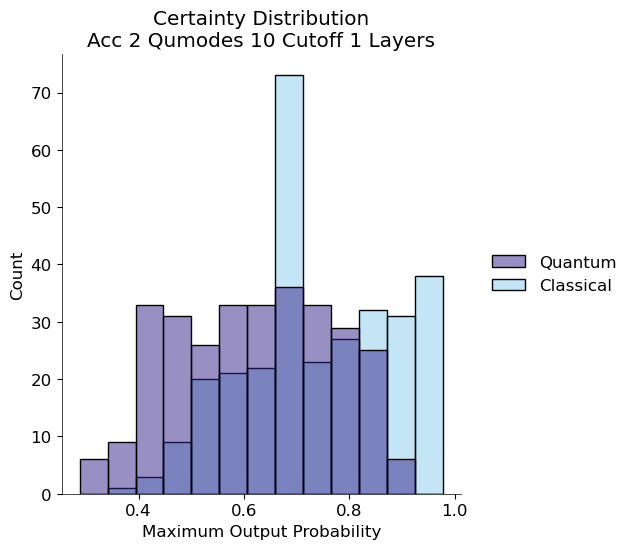

For Number of Qumodes:  2  Cutoff:  10  Layers:  2
Highest Accuracy Experiments
Quantum: 42 
Classical: 227
10/10 [==============================] - 0s 3ms/step - loss: 0.4304 - accuracy: 0.8667
Average Maximum Output Probability
Quantum: 0.49321112036705017
Classical: 0.7618494629859924


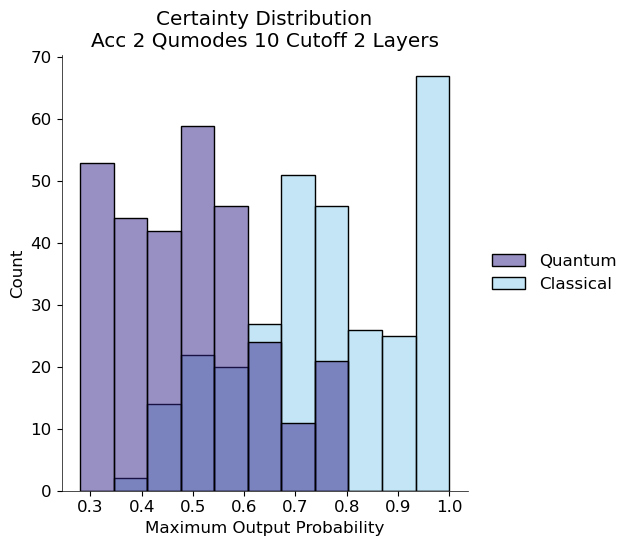

For Number of Qumodes:  2  Cutoff:  10  Layers:  3
Highest Accuracy Experiments
Quantum: 36 
Classical: 142
10/10 [==============================] - 0s 3ms/step - loss: 0.4538 - accuracy: 0.8167
Average Maximum Output Probability
Quantum: 0.8302429914474487
Classical: 0.7404360175132751


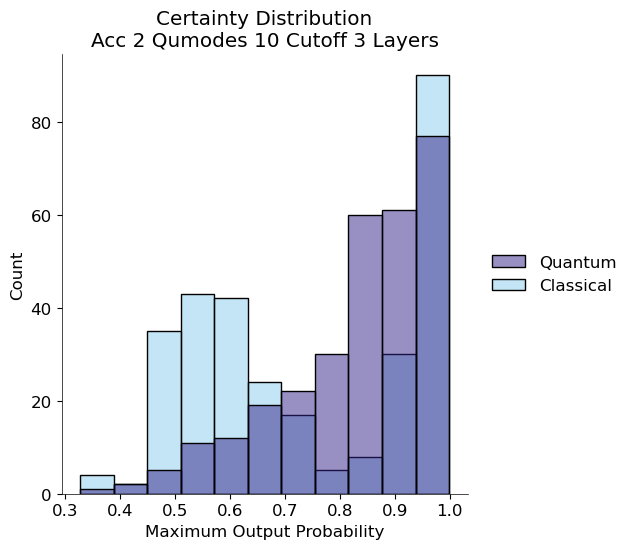

In [14]:
import numpy as np
from quantum_base import Net as Net_orig
from quantum_base import OPTIMIZER, LOSS_FUNCTION
from quantum_base_kerr import Net as Net_kerr
from data import generate_synthetic_dataset_easy
import seaborn as sns
from itertools import product
test_data, validate_data = generate_synthetic_dataset_easy(num_datapoints=1000, n_features=8, n_classes=4)

test_data_kerr, validate_data_kerr = generate_synthetic_dataset_easy(num_datapoints=1000, n_features=15, n_classes=4)

df_orig['model'] = Net_orig
df_orig['exp_folder'] = '/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep/'
df_kerr['model'] = Net_kerr
df_kerr['exp_folder'] = '/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Kerr/'
def plot_network_certainty_dist(df, metric='acc', fname='network_certainty_dist', validate_data=validate_data):  
    df_final = copy.deepcopy(df)
    df_final[metric] = df[metric].apply(lambda x: x[-1])
    df_quantum = df_final[df_final['network_type']=='quantum']
    df_quantum = df_quantum[df_quantum['num_qumodes']==2]
    df_classical = df_final[df_final['network_type']=='classical']

    exp_folder = df_quantum['exp_folder'].unique()[0]
 
    for n in df_quantum['num_qumodes'].unique():
        for c in df_quantum[df_quantum['num_qumodes']==n]['cutoff'].unique():
            for nl in df_quantum.loc[(df_quantum['num_qumodes']==n) & (df_quantum['cutoff']==c)]['n_layers'].unique():
                exp_quantum = df_quantum.loc[(df_quantum['num_qumodes']==n) & (df_quantum['cutoff']==c) & (df_quantum['n_layers']==nl)][metric]
                exp_classical = df_classical.loc[(df_classical['num_qumodes']==n) & (df_classical['n_layers']==nl)][metric]
                if len(exp_quantum) == 0 or len(exp_classical) == 0:
                    continue
                else:
                    exp_quantum = exp_quantum.idxmax()
                    exp_classical = exp_classical.idxmax()
                    print('For Number of Qumodes: ', n, ' Cutoff: ', c, ' Layers: ', nl)
                    print(f'Highest Accuracy Experiments\nQuantum: {exp_quantum} \nClassical: {exp_classical}')
                    model = df_final['model'][exp_quantum](
                        network_type='quantum',
                        num_qumodes=n,
                        n_layers=nl,
                        cutoff=c,
                        max_initial_weight=0.15
                    )
                    model.load_weights(f'{exp_folder}{exp_quantum}/weights/weight99.ckpt', by_name=False).expect_partial()
                    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=["accuracy"])
                    output_quantum = model(validate_data[0])

                    loss_quantum, acc_quantum = model.evaluate(validate_data[0], validate_data[1])

                    model_classical = df_final['model'][exp_classical](
                        network_type='classical',
                        num_qumodes=n,
                        n_layers=nl,
                        cutoff=1,
                        max_initial_weight=0.15
                    )

                    model_classical.load_weights(f'{exp_folder}{exp_classical}/weights/weight99.ckpt', by_name=False).expect_partial()
                    model_classical.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=["accuracy"])
                    output_classical = model_classical(validate_data[0])

                    loss_classical, acc_classical = model_classical.evaluate(validate_data[0], validate_data[1])
                    
                    plot_df = pd.DataFrame(columns=['Quantum', 'Classical'])
                    plot_df['Quantum']=np.max(output_quantum, axis=1)
                    plot_df['Classical']=np.max(output_classical, axis=1)

                    print(f'Average Maximum Output Probability\nQuantum: {np.mean(np.max(output_quantum, axis=1))}\nClassical: {np.mean(np.max(output_classical, axis=1))}')
                    sns.displot(plot_df)
                    plt.xlabel(f'Maximum Output Probability')
                    plt.title(f'Certainty Distribution\n{metric.capitalize()} {n} Qumodes {c} Cutoff {nl} Layers')
                    plt.show()

            
plot_network_certainty_dist(df_kerr, validate_data=validate_data_kerr)

For Number of Qumodes:  2  Cutoff:  9  Layers:  3
Highest Accuracy Experiments
Quantum: 52 
Classical: 282
10/10 [==============================] - 0s 2ms/step - loss: 0.9005 - accuracy: 0.8233
Average maximum output probabilitiy
Quantum: 0.29879942536354065
Classical: 0.463905930519104


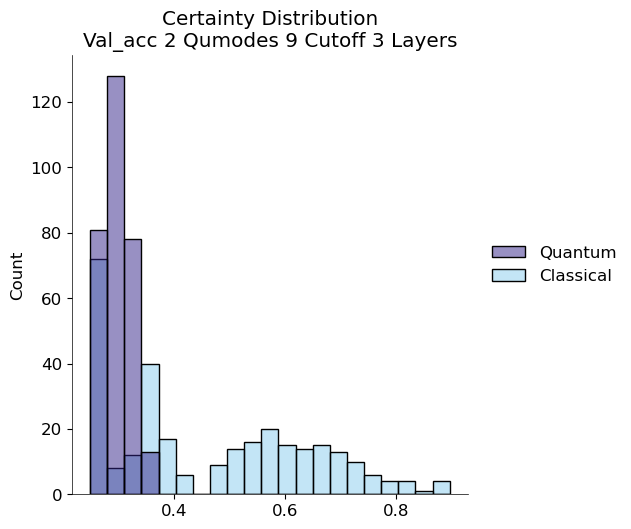

For Number of Qumodes:  2  Cutoff:  9  Layers:  2
Highest Accuracy Experiments
Quantum: 213 
Classical: 326
10/10 [==============================] - 0s 2ms/step - loss: 0.9769 - accuracy: 0.6867
Average maximum output probabilitiy
Quantum: 0.27319127321243286
Classical: 0.5096492767333984


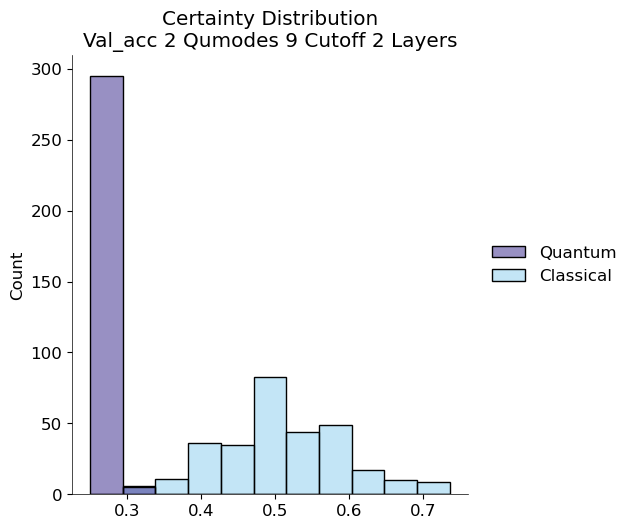

For Number of Qumodes:  2  Cutoff:  9  Layers:  1
Highest Accuracy Experiments
Quantum: 526 
Classical: 254
10/10 [==============================] - 0s 2ms/step - loss: 0.9284 - accuracy: 0.7400
Average maximum output probabilitiy
Quantum: 0.28906744718551636
Classical: 0.44587066769599915


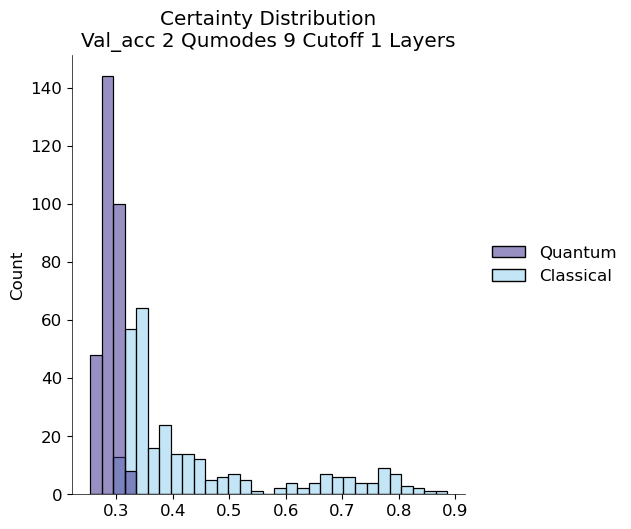

For Number of Qumodes:  2  Cutoff:  9  Layers:  4
Highest Accuracy Experiments
Quantum: 250 
Classical: 343
10/10 [==============================] - 0s 2ms/step - loss: 1.0736 - accuracy: 0.5400
Average maximum output probabilitiy
Quantum: 0.29711732268333435
Classical: 0.4636427164077759


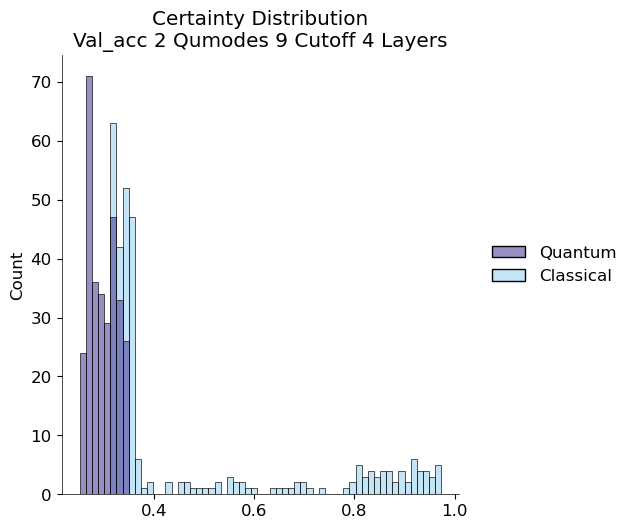

For Number of Qumodes:  2  Cutoff:  9  Layers:  5
Highest Accuracy Experiments
Quantum: 178 
Classical: 393
10/10 [==============================] - 0s 2ms/step - loss: 1.0344 - accuracy: 0.5833
Average maximum output probabilitiy
Quantum: 0.27165547013282776
Classical: 0.4160047471523285


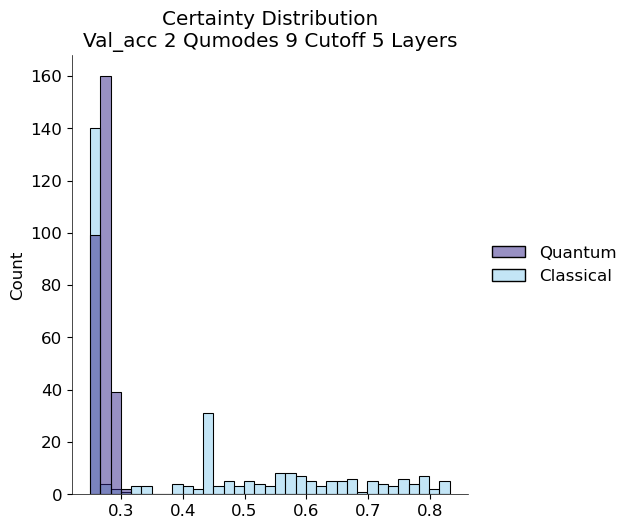

For Number of Qumodes:  2  Cutoff:  8  Layers:  3
Highest Accuracy Experiments
Quantum: 51 
Classical: 282
10/10 [==============================] - 0s 2ms/step - loss: 0.9005 - accuracy: 0.8233
Average maximum output probabilitiy
Quantum: 0.28191059827804565
Classical: 0.463905930519104


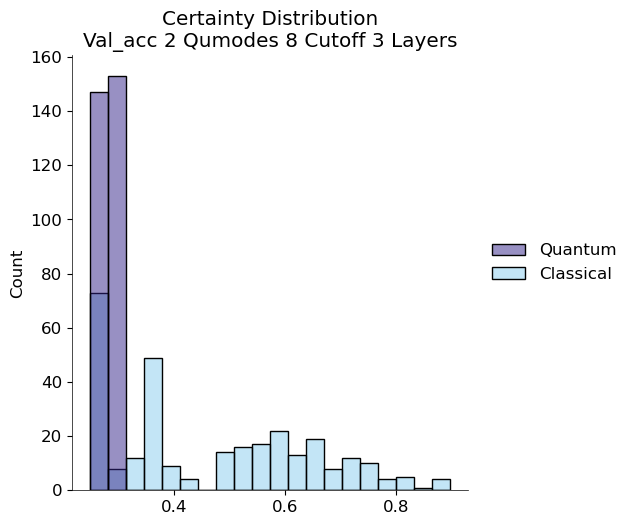

For Number of Qumodes:  2  Cutoff:  8  Layers:  2
Highest Accuracy Experiments
Quantum: 30 
Classical: 326
10/10 [==============================] - 0s 2ms/step - loss: 0.9769 - accuracy: 0.6867
Average maximum output probabilitiy
Quantum: 0.2880552411079407
Classical: 0.5096492767333984


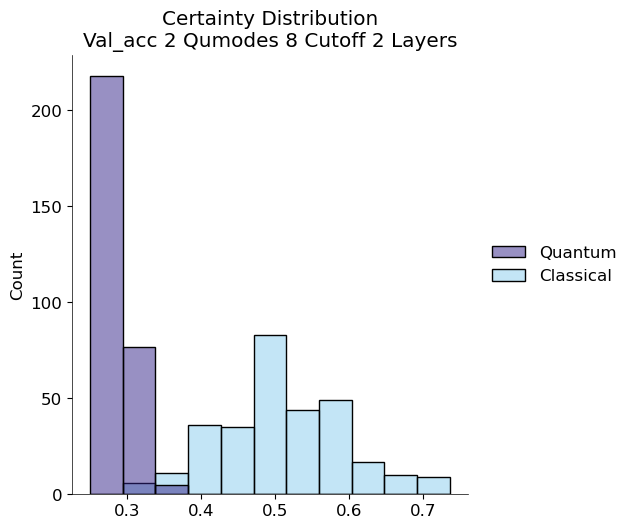

For Number of Qumodes:  2  Cutoff:  8  Layers:  1
Highest Accuracy Experiments
Quantum: 193 
Classical: 254
10/10 [==============================] - 0s 2ms/step - loss: 0.9284 - accuracy: 0.7400
Average maximum output probabilitiy
Quantum: 0.2870723605155945
Classical: 0.44587066769599915


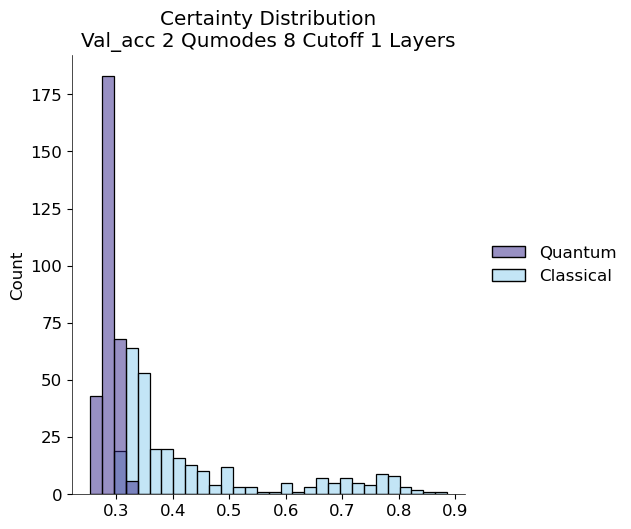

For Number of Qumodes:  2  Cutoff:  8  Layers:  5
Highest Accuracy Experiments
Quantum: 86 
Classical: 393
10/10 [==============================] - 0s 2ms/step - loss: 1.0344 - accuracy: 0.5833
Average maximum output probabilitiy
Quantum: 0.2851502299308777
Classical: 0.4160047471523285


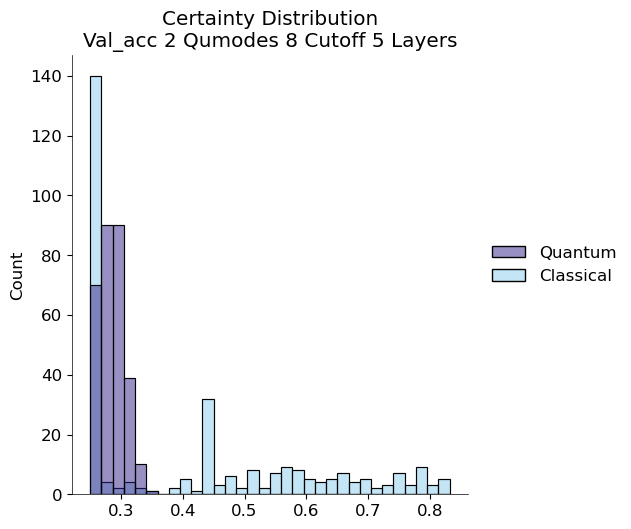

For Number of Qumodes:  2  Cutoff:  8  Layers:  4
Highest Accuracy Experiments
Quantum: 157 
Classical: 343
10/10 [==============================] - 0s 2ms/step - loss: 1.0736 - accuracy: 0.5400
Average maximum output probabilitiy
Quantum: 0.2822529077529907
Classical: 0.4636427164077759


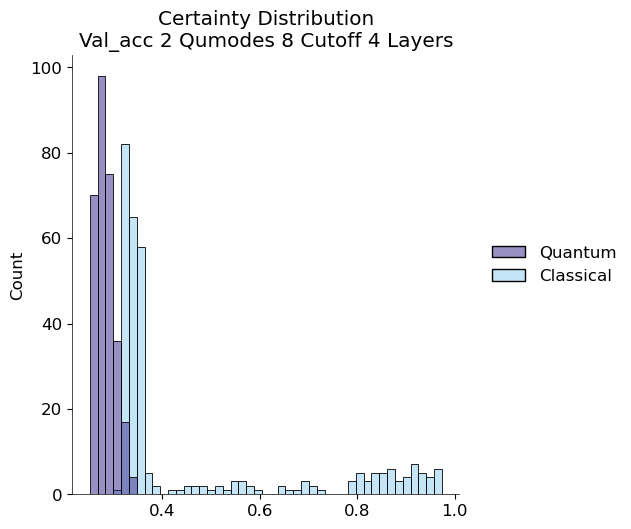

For Number of Qumodes:  2  Cutoff:  3  Layers:  2
Highest Accuracy Experiments
Quantum: 202 
Classical: 326
10/10 [==============================] - 0s 1ms/step - loss: 0.9769 - accuracy: 0.6867
Average maximum output probabilitiy
Quantum: 0.2864888906478882
Classical: 0.5096492767333984


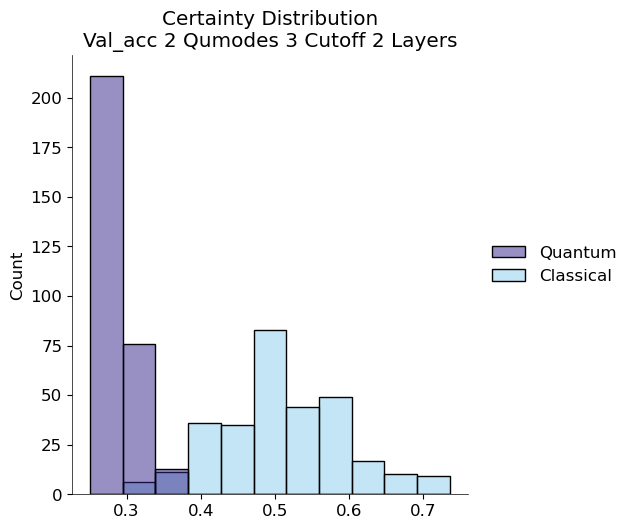

For Number of Qumodes:  2  Cutoff:  3  Layers:  1
Highest Accuracy Experiments
Quantum: 4 
Classical: 254
10/10 [==============================] - 0s 2ms/step - loss: 0.9284 - accuracy: 0.7400
Average maximum output probabilitiy
Quantum: 0.2899494767189026
Classical: 0.44587066769599915


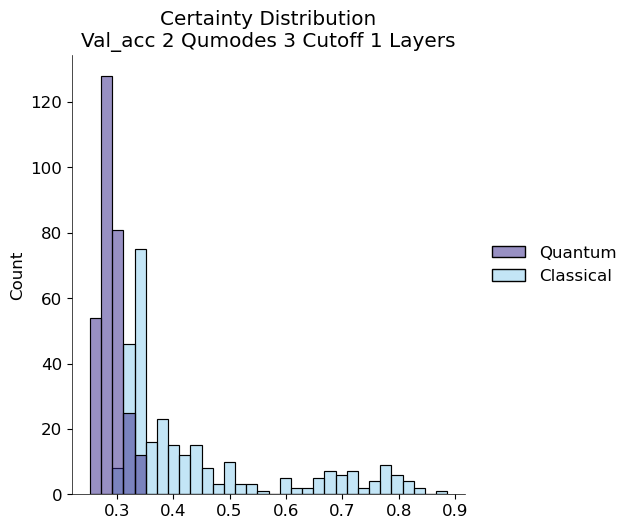

For Number of Qumodes:  2  Cutoff:  3  Layers:  4
Highest Accuracy Experiments
Quantum: 238 
Classical: 343
10/10 [==============================] - 0s 2ms/step - loss: 1.0736 - accuracy: 0.5400
Average maximum output probabilitiy
Quantum: 0.2843940258026123
Classical: 0.4636427164077759


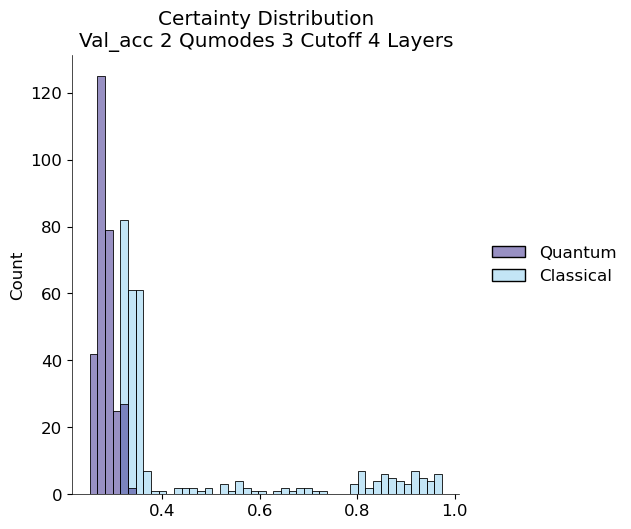

For Number of Qumodes:  2  Cutoff:  3  Layers:  3
Highest Accuracy Experiments
Quantum: 550 
Classical: 282
10/10 [==============================] - 0s 2ms/step - loss: 0.9005 - accuracy: 0.8233
Average maximum output probabilitiy
Quantum: 0.29333484172821045
Classical: 0.463905930519104


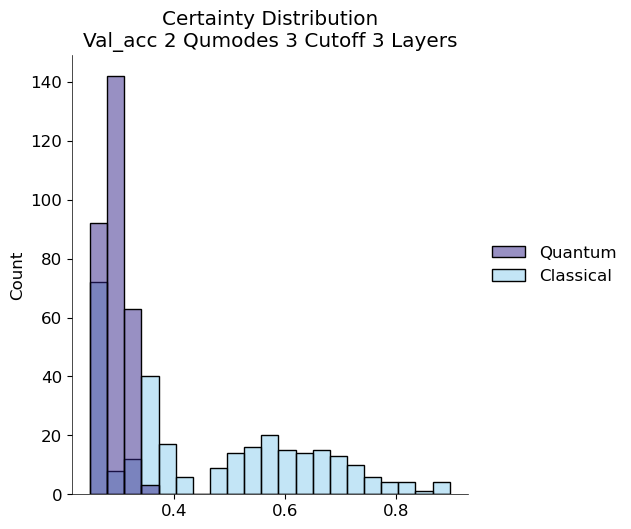

For Number of Qumodes:  2  Cutoff:  3  Layers:  5
Highest Accuracy Experiments
Quantum: 496 
Classical: 393
10/10 [==============================] - 0s 2ms/step - loss: 1.0344 - accuracy: 0.5833
Average maximum output probabilitiy
Quantum: 0.2892346978187561
Classical: 0.4160047471523285


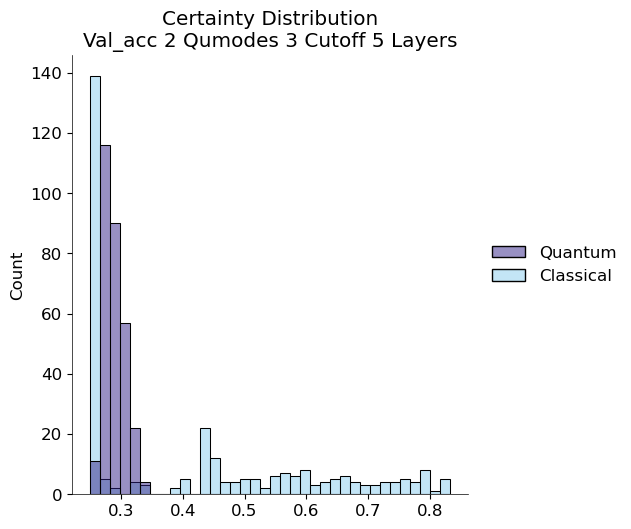

For Number of Qumodes:  2  Cutoff:  7  Layers:  1
Highest Accuracy Experiments
Quantum: 190 
Classical: 254
10/10 [==============================] - 0s 2ms/step - loss: 0.9284 - accuracy: 0.7400
Average maximum output probabilitiy
Quantum: 0.29621022939682007
Classical: 0.44587066769599915


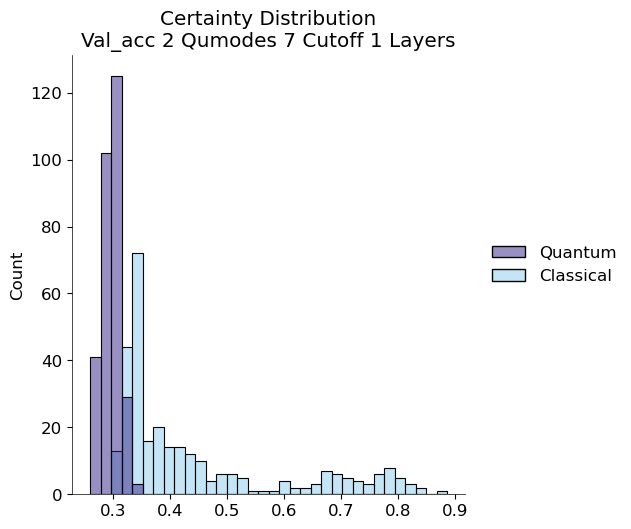

For Number of Qumodes:  2  Cutoff:  7  Layers:  2
Highest Accuracy Experiments
Quantum: 211 
Classical: 326
10/10 [==============================] - 0s 1ms/step - loss: 0.9769 - accuracy: 0.6867
Average maximum output probabilitiy
Quantum: 0.2852882444858551
Classical: 0.5096492767333984


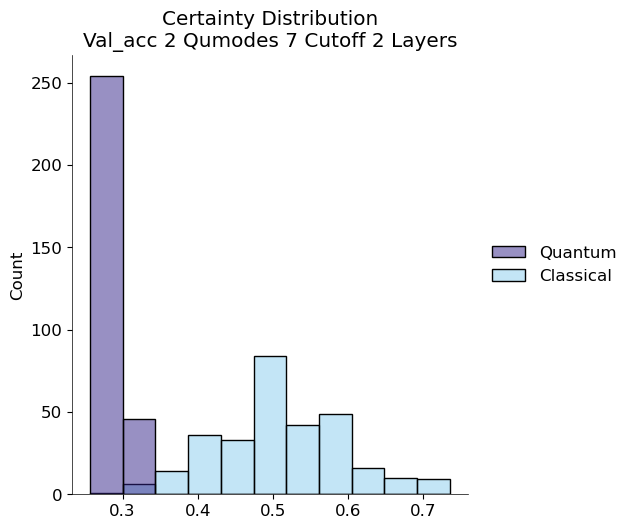

For Number of Qumodes:  2  Cutoff:  7  Layers:  3
Highest Accuracy Experiments
Quantum: 136 
Classical: 282
10/10 [==============================] - 0s 1ms/step - loss: 0.9005 - accuracy: 0.8233
Average maximum output probabilitiy
Quantum: 0.2760825455188751
Classical: 0.463905930519104


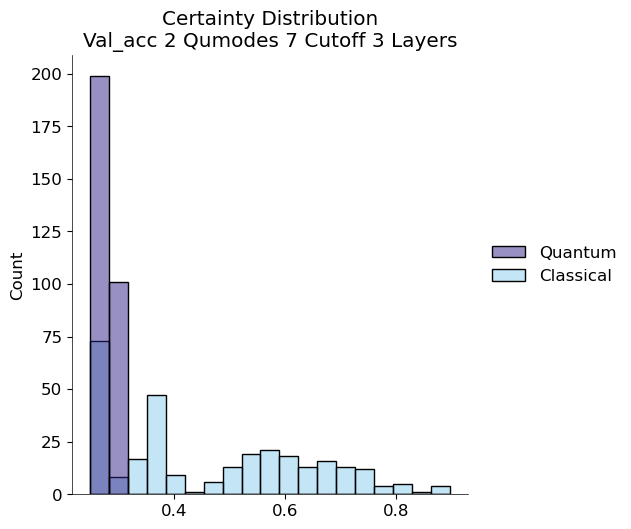

For Number of Qumodes:  2  Cutoff:  7  Layers:  4
Highest Accuracy Experiments
Quantum: 243 
Classical: 343
10/10 [==============================] - 0s 3ms/step - loss: 1.0736 - accuracy: 0.5400
Average maximum output probabilitiy
Quantum: 0.2829243242740631
Classical: 0.4636427164077759


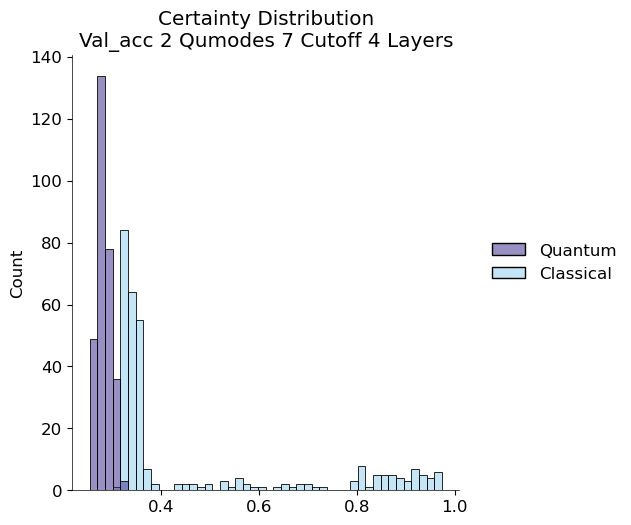

For Number of Qumodes:  2  Cutoff:  7  Layers:  5
Highest Accuracy Experiments
Quantum: 502 
Classical: 393
10/10 [==============================] - 0s 2ms/step - loss: 1.0344 - accuracy: 0.5833
Average maximum output probabilitiy
Quantum: 0.29272499680519104
Classical: 0.4160047471523285


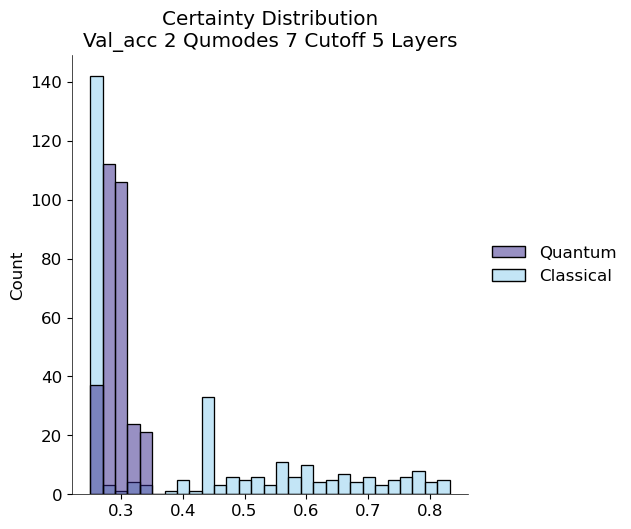

For Number of Qumodes:  2  Cutoff:  5  Layers:  1
Highest Accuracy Experiments
Quantum: 607 
Classical: 254
10/10 [==============================] - 0s 2ms/step - loss: 0.9284 - accuracy: 0.7400
Average maximum output probabilitiy
Quantum: 0.2789345979690552
Classical: 0.44587066769599915


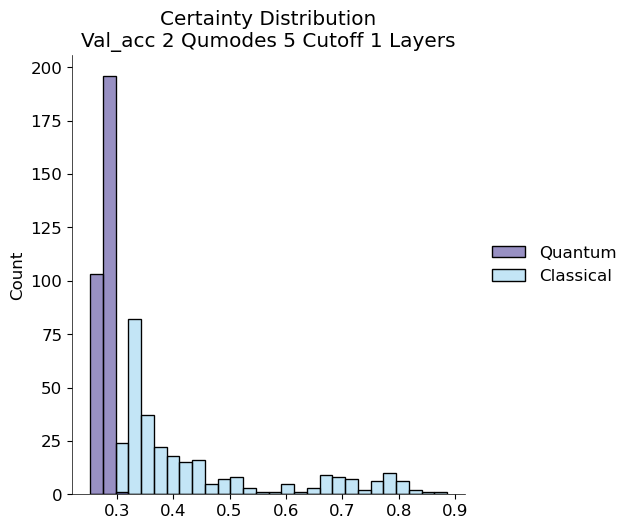

For Number of Qumodes:  2  Cutoff:  5  Layers:  5
Highest Accuracy Experiments
Quantum: 499 
Classical: 393
10/10 [==============================] - 0s 2ms/step - loss: 1.0344 - accuracy: 0.5833
Average maximum output probabilitiy
Quantum: 0.2905138432979584
Classical: 0.4160047471523285


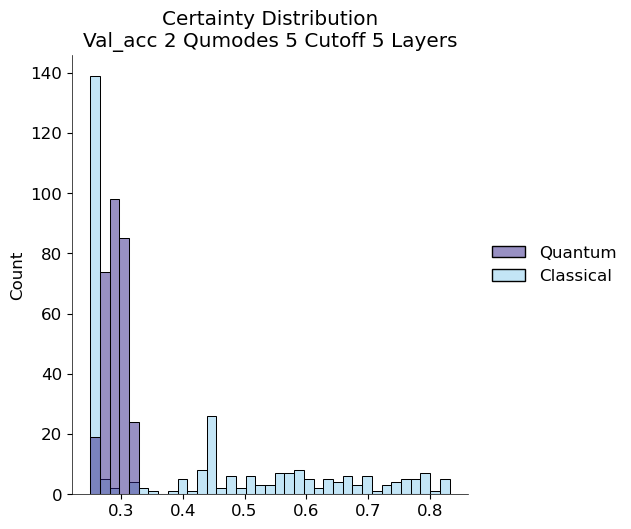

For Number of Qumodes:  2  Cutoff:  5  Layers:  4
Highest Accuracy Experiments
Quantum: 60 
Classical: 343
10/10 [==============================] - 0s 1ms/step - loss: 1.0736 - accuracy: 0.5400
Average maximum output probabilitiy
Quantum: 0.28447845578193665
Classical: 0.4636427164077759


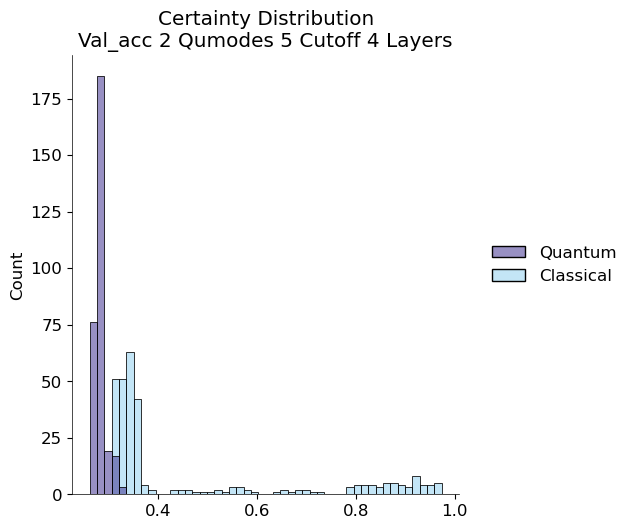

For Number of Qumodes:  2  Cutoff:  5  Layers:  2
Highest Accuracy Experiments
Quantum: 16 
Classical: 326
10/10 [==============================] - 0s 1ms/step - loss: 0.9769 - accuracy: 0.6867
Average maximum output probabilitiy
Quantum: 0.2872728705406189
Classical: 0.5096492767333984


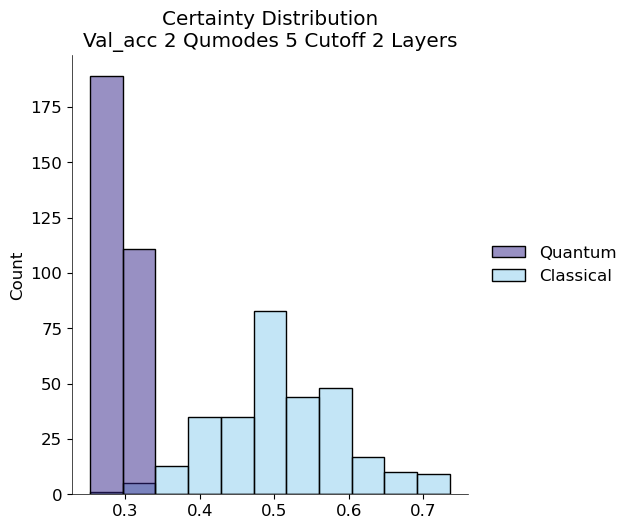

For Number of Qumodes:  2  Cutoff:  5  Layers:  3
Highest Accuracy Experiments
Quantum: 133 
Classical: 282
10/10 [==============================] - 0s 2ms/step - loss: 0.9005 - accuracy: 0.8233
Average maximum output probabilitiy
Quantum: 0.2847333550453186
Classical: 0.463905930519104


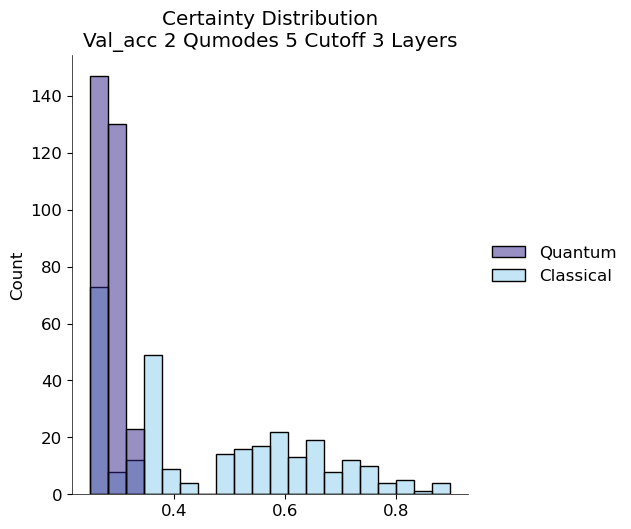

In [55]:
plot_network_certainty_dist(df_orig, validate_data=validate_data, metric='acc')